## Machine Learning

### Time series analysis - predict levels of violence based on previous weeks.
We will attempt to predict levels of violence for upcoming weeks based on data from previous weeks. The production of this data could potentially be automated with a script and displayed on the Nepal Monitor platform alongside current data. Any predictions would likely need to have interpretable metrics and be displayed with a confidence score for purposes of accountability

### Data Preparation:

In [1]:
#list available files in directory
print('Raw Files:')
! ls Data
print('\nProcessed Files:')
! ls Data/output/

Raw Files:
1519759656_39328483.csv
2017 PMP Data Final No Duplicates.xlsx
Federal_VDC_Relation_web_clean.xlsx
Federal_VDC_Relation_web.xlsx
nepalmonitor-reports.csv
nepalmonitor-reports_old.csv
nepal_population_household_ward-2011.csv
NM_2016_17export.csv
npl_polbanda_adm5_wad_25k_50k_sdn_wgs84.csv
output

Processed Files:
District_Province_Population	 NM_2017-18_timeshift
NM_2016_17clean.csv		 NM_2017-18_timeshift_province
NM_2017-18_onehot_day		 pop_incidents_VDC.csv
NM_2017-18_onehot_week		 sources_vdc.csv
NM_2017-18_onehot_week_province


In [2]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns

#set up a custom qualitative color palette
xkcd_colors = ['purple','green','blue','pink','brown','red','light blue',\
              'tan','light green','magenta','yellow','sky blue','teal','orange','light purple']
catpal = sns.xkcd_palette(xkcd_colors)


#Import Primary Data Frames
cleanpath='Data/output/NM_2016_17clean.csv'#clean 2017 dataset
newpath = 'Data/nepalmonitor-reports.csv'#NM latest export - new site version
df = pd.read_csv(cleanpath)
new_df = pd.read_csv(newpath)

print(df.shape[0],'x',df.shape[1])
print(new_df.shape[0], 'x',new_df.shape[1])

6630 x 68
7203 x 55


Previous data cleaning efforts have focused on export data, from the previous Nepal Monitor platform. As of November 2018 a new version of NepalMonitor has been deployed, with a significantly streamlined export file. Machine Learning will focus on this new file format (new_df). 

In [3]:
#convert 'INCIDENT DATE' column to date time objects
    
new_df.loc[:,'Event Date'] = pd.to_datetime(new_df.loc[:,'Event Date'])
new_df.index = pd.to_datetime(new_df.loc[:,'Event Date'])
#new_df = new_df.loc['2017':'2018',:]# < taken out to have part of the 2017 data

print(df.shape)
print(new_df.shape)
new_df.head()

(6630, 68)
(7203, 55)


,#,Title,Nepali Title,Event Date,Publication Date,Location,Description,Nepali Description,Tags,Latitude,...,Youth raped,Total abducted,Female abducted,Youth abducted,Total damaged buildings,Severely damaged buildings,Total damaged vehicles,Severely damaged vehicles,Election-related cause - primary,Election-related cause - secondary
Event Date,,,,,,,,,,,,,,,,,,,,,
2018-12-31,21793,Complaint registered against rape,चकलेट दिन्छु भन्दै ५ बर्षीया बालिका बलात्कार।,2018-12-31,2018-12-31,"Province 2, Parsa, Pakahamainpur",A complaint against 19 years old Dev Kumar Pat...,पर्साको पकहामैनपुर गाउँपालिका १ मा धोरेमा ५ बर...,GBV\nChildren’s Rights,27.03046158726636,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-12-31,21803,Man held on charge of attempted rape,बलात्कार प्रयास घटनाका आरोपित गिरफ्तार ।,2018-12-31,2019-01-01,"Province 1, Morang, Biratnagar, Ward 10",Police have arrested 25 years old Gyanendra Sa...,१८ वर्षीया युवतीलाई बलात्कार प्रयास गरेको आरोप...,GBV,26.454562034856874,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-12-31,21804,Agitating civil servants take to streets,समायोजनविरुद्ध सडकमै उत्रिए निजामती कर्मचारी।,2018-12-31,2019-01-01,"Province 3, Kathmandu",Agitating civil servants today took to the str...,कर्मचारी समायोजन अध्यादेशको विरोधमा निजामती कर...,Governance,27.7058766168406,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-31,21810,Complaint registered against rape,बलात्कार घटनाका आरोपितविरूद्ध उजुरी दर्ता।,2018-12-31,2019-01-02,"Province 2, Parsa",A complaint against 19 years old Dev Kumar Pat...,पाँच वर्षीया बालिकालाई बलात्कार गरेको आरोपमा प...,GBV\nChildren’s Rights,27.173588000000002,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2018-12-30,21779,Police arrests youth on rape charge,जवरजस्ती करणी गरेको अभियोगमा पक्राउ ।,2018-12-30,2018-12-30,"Province 5, Rukum East, Bhume, Ward 2",Police on Sunday arrested 22-year-old Laxman B...,पुथाउत्तरगंगा गाउँपालिका-१२ घर भई भूमे गाउँपाल...,GBV\nChildren’s Rights,28.545244075518408,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN


In [4]:
#Drop out unneeded columns - leaving in provinces doesn't seem to break anything
new_drop = ['#','Title','Nepali Title', 'Ward','Publication Date','Event Date',
            'Nepali Description','Tags','Location','Latitude','Longitude']

test_df = new_df.dropna(axis=1, how='all')#.sort_index(axis=1)

test_df.drop(new_drop, axis=1, inplace=True)

In [5]:
#Fix minor inconsistencies in export file variables to facilitate dummy columns creation

#Some cells include the same cateogry name repeated on a new line. Strip out the second line.
def strip_newline(string):
    if type(string) == str:
        return string.split('\n')[0]#.lower().replace('nonviolent', 'non-violent').strip()
    else:
        return string

#Strip out anything contained in () and make everything lowercase
def strip_paren(string):
    if type(string) == str:
        return string.split('(')[0].lower()#.replace('nonviolent', 'non-violent').replace('noyouth', 'no-youth').strip()
    else:
        return string

#train_df = train_df.applymap(strip_paren)
full_df = test_df.applymap(strip_newline).applymap(strip_paren)

#train_df.append(test_df) < it looks like the variables are coded differently let's just use 1 dataset for now
full_df.loc[:,'Total killed'] = (full_df.loc[:,'Total killed'] == '1').astype(int)



In [6]:
#One-hot encode categorical columns
dummies = ['Violent / Nonviolent', 'Onesided / Twosided', 'Collective / Interpersonal', 'Event Form - Primary', 'Event Form - Secondary', 'Weapons', 'Cause - Primary', 'Cause - Secondary', 'Actor 1 - Affiliation', 'Actor 1 - Entity', 'Actor 1 - Youth/non-youth', 'Actor 2 - Target', 'Actor 2 - Affiliation','Actor 2 - Youth/non-youth']

incidents_date_test = pd.get_dummies(full_df, columns=dummies, dummy_na=False)

#strip out blank dummy categories 
for col in dummies:
    badstr = col+'_'
    if badstr in incidents_date_test.columns:
        incidents_date.drop(badstr, inplace=True, axis=1)
        print('dropped useless category:', badstr)
    
#aggrigate into weekly and daily dataframes
in_week = incidents_date_test.resample('W').sum()
in_day = incidents_date_test.resample('D').sum()

#Create weekly aggrigations by province
in_week_province = incidents_date_test.groupby('Province').resample('W').sum()

#Export data-frames CSV for opensource analysis
in_week.to_csv('Data/output/NM_2017-18_onehot_week')
in_day.to_csv('Data/output/NM_2017-18_onehot_day')
in_week_province.to_csv('Data/output/NM_2017-18_onehot_week_province')

print(in_week_province.shape)
#print(in_day_province.shape)
in_week_province.loc[('province 3',),:].head()


(737, 321)


,Total killed,Female killed,Youth killed,Total injured,Female injured,Total raped,Female raped,Youth raped,Total abducted,Female abducted,...,Actor 2 - Affiliation_security forces - apf,Actor 2 - Affiliation_security forces - army,Actor 2 - Affiliation_security forces - police,Actor 2 - Affiliation_security forces - security forces,Actor 2 - Affiliation_students,Actor 2 - Affiliation_unclear,Actor 2 - Youth/non-youth_na,Actor 2 - Youth/non-youth_noyouth,Actor 2 - Youth/non-youth_unknown,Actor 2 - Youth/non-youth_youth
Event Date,,,,,,,,,,,,,,,,,,,,,
2017-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2017-01-08,2.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,2.0,2.0,1.0
2017-01-15,2.0,0.0,1.0,4.0,3.0,2.0,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,5.0
2017-01-22,1.0,0.0,0.0,33.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,7.0,1.0,3.0,1.0
2017-01-29,3.0,1.0,2.0,18.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,4.0,3.0,1.0,3.0


Above, we have created a separate column for each variable tracked by the project, and given it a 1 if it was marked and a 0 if not (one hot encoding) and aggregated them by day and week, we have also created a separate data frame grouped by province for province-wise analysis, and saved all these data frames to CSV, so others interested in using the data can grab it directly in those formats

In [7]:
#function for converting pandas time series dataframe to training set for supervised learning
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
        Returns:
        Pandas DataFrame of series framed for supervised learning.
        https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%03d)' % (df.columns[j], i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (df.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%03d)' % (df.columns[j], i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
#Create a time shifted dataframe of all variables.
def make_timeshift(df, lookback):
    time_shift = series_to_supervised(df, lookback, dropnan=False).fillna(0)
    return time_shift

lookback=1
time_shift_week = make_timeshift(in_week, lookback)
time_shift_day = make_timeshift(in_day, lookback)
time_shift_province = make_timeshift(in_week_province, lookback)
print(time_shift_day.shape)
print(time_shift_week.shape)
test = pd.concat([time_shift_week['Total killed(t-001)'],time_shift_week['Total killed(t)']],axis=1)
print(test[:5])
#Save this for posterity
time_shift_week.to_csv('Data/output/NM_2017-18_timeshift')
time_shift_week.to_csv('Data/output/NM_2017-18_timeshift_province')

time_shift_province.head()



(730, 642)
(106, 642)
            Total killed(t-001)  Total killed(t)
Event Date                                      
2017-01-01                  0.0                2
2017-01-08                  2.0                9
2017-01-15                  9.0               11
2017-01-22                 11.0                4
2017-01-29                  4.0                8


Total killed(t-001)  Female killed(t-001)  \
Province   Event Date                                              
province 1 2017-01-01                  0.0                   0.0   
           2017-01-08                  1.0                   0.0   
           2017-01-15                  2.0                   0.0   
           2017-01-22                  0.0                   0.0   
           2017-01-29                  2.0                   0.0   

                       Youth killed(t-001)  Total injured(t-001)  \
Province   Event Date                                              
province 1 2017-01-01                  0.0                   0.0   
           2017-01-08                  0.0                   2.0   
           2017-01-15                  0.0                   4.0   
           2017-01-22                  0.0                   0.0   
           2017-01-29                  0.0                   3.0   

                       Female injured(t-001)  Total raped(t-001)  \
Province   Event Date                                              
province 1 2017-01-01                    0.0                 0.0   
           2017-01-08                    0.0                 0.0   
           2017-01-15                    0.0                 1.0   
           2017-01-22                    0.0                 1.0   
           2017-01-29                    0.0                 1.0   

                       Female raped(t-001)  Youth raped(t-001)  \
Province   Event Date                                            
province 1 2017-01-01                  0.0                 0.0   
           2017-01-08                  0.0                 0.0   
           2017-01-15                  1.0                 1.0   
           2017-01-22                  1.0                 1.0   
           2017-01-29                  1.0                 0.0   

                       Total abducted(t-001)  Female abducted(t-001)  \
Province   Event Date                                                  
province 1 2017-01-01                    0.0                     0.0   
           2017-01-08                    0.0                     0.0   
           2017-01-15                    0.0                     0.0   
           2017-01-22                    0.0                     0.0   
           2017-01-29                    0.0                     0.0   

                                      ...                  \
Province   Event Date                 ...                   
province 1 2017-01-01                 ...                   
           2017-01-08                 ...                   
           2017-01-15                 ...                   
           2017-01-22                 ...                   
           2017-01-29                 ...                   

                       Actor 2 - Affiliation_security forces - apf(t)  \
Province   Event Date                                                   
province 1 2017-01-01                                             0.0   
           2017-01-08                                             0.0   
           2017-01-15                                             0.0   
           2017-01-22                                             0.0   
           2017-01-29                                             0.0   

                       Actor 2 - Affiliation_security forces - army(t)  \
Province   Event Date                                                    
province 1 2017-01-01                                              0.0   
           2017-01-08                                              0.0   
           2017-01-15                                              0.0   
           2017-01-22                                              0.0   
           2017-01-29                                              0.0   

                       Actor 2 - Affiliation_security forces - police(t)  \
Province   Event Date                                                      
province 1 20

The functions above take the aggregated data and "time-shift" it so that can be used for supervised learning. It essentially puts a series of weeks on the same row as a given number of previous weeks represented by the "lookback" variable. The previous weeks will be used as input and the subsequent weeks will be used to train and score predictions based on that output. Again we have saved this data to CSV so others can grab it directly for analysis. 

Next we will create the X and y sets needed to to train the models, as well as a holdout set that the models will not "see" during training.

In [10]:
#Create X y - with holdhout split 
def create_X_y(df, holdpc=.25):
    holdsize = int(holdpc * len(df.index))
    y = df.loc[:,'Total killed(t)':].iloc[:-holdsize,:]
    X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-001)'].iloc[:-holdsize,:]
    
    holdout_y = df.loc[:,'Total killed(t)':].iloc[-holdsize:,:]
    holdout_X = df.loc[:,:'Actor 2 - Youth/non-youth_youth(t-001)'].iloc[-holdsize:,:]

    return X, y, holdout_X, holdout_y

X_day, y_day, holdout_X_day, holdout_y_day = create_X_y(time_shift_day)

X_week, y_week, holdout_X_week, holdout_y_week = create_X_y(time_shift_week)

X_province, y_province, holdout_X_province, holdout_y_province = create_X_y(time_shift_province)

for x in [X_day, y_day, holdout_X_day, holdout_y_day, X_week, y_week, holdout_X_week, holdout_y_week]:
    print(x.shape)


y_province.head()

(548, 321)
(548, 321)
(182, 321)
(182, 321)
(80, 321)
(80, 321)
(26, 321)
(26, 321)


Total killed(t)  Female killed(t)  Youth killed(t)  \
Province   Event Date                                                       
province 1 2017-01-01              1.0               0.0              0.0   
           2017-01-08              2.0               0.0              0.0   
           2017-01-15              0.0               0.0              0.0   
           2017-01-22              2.0               0.0              0.0   
           2017-01-29              4.0               0.0              2.0   

                       Total injured(t)  Female injured(t)  Total raped(t)  \
Province   Event Date                                                        
province 1 2017-01-01               2.0                0.0             0.0   
           2017-01-08               4.0                0.0             1.0   
           2017-01-15               0.0                0.0             1.0   
           2017-01-22               3.0                0.0             1.0   
           2017-01-29               3.0                0.0             4.0   

                       Female raped(t)  Youth raped(t)  Total abducted(t)  \
Province   Event Date                                                       
province 1 2017-01-01              0.0             0.0                0.0   
           2017-01-08              1.0             1.0                0.0   
           2017-01-15              1.0             1.0                0.0   
           2017-01-22              1.0             0.0                0.0   
           2017-01-29              4.0             2.0                0.0   

                       Female abducted(t)                 ...                  \
Province   Event Date                                     ...                   
province 1 2017-01-01                 0.0                 ...                   
           2017-01-08                 0.0                 ...                   
           2017-01-15                 0.0                 ...                   
           2017-01-22                 0.0                 ...                   
           2017-01-29                 0.0                 ...                   

                       Actor 2 - Affiliation_security forces - apf(t)  \
Province   Event Date                                                   
province 1 2017-01-01                                             0.0   
           2017-01-08                                             0.0   
           2017-01-15                                             0.0   
           2017-01-22                                             0.0   
           2017-01-29                                             0.0   

                       Actor 2 - Affiliation_security forces - army(t)  \
Province   Event Date                                                    
province 1 2017-01-01                                              0.0   
           2017-01-08                                              0.0   
           2017-01-15                                              0.0   
           2017-01-22                                              0.0   
           2017-01-29                                              0.0   

                       Actor 2 - Affiliation_security forces - police(t)  \
Province   Event Date                                                      
province 1 2017-01-01                                                0.0   
           2017-01-08                                                0.0   
           2017-01-15                                                0.0   
           2017-01-22                                                0.0   
           2017-01-29                                                0.0   

                       Actor 2 - Affiliation_security forces - security forces (t)  \
Province   Event Date                                                                
province 1 2017-01-01                                                0.0             
      

When the holdout percentage (holdout_pc) is set to .25 the holdout set represents approximately the final 6 months of 2018.  The need for the holdout set is complicated by the fact that this is time series analysis. Procedures needed to be tweaked to ensure that the model *never* "sees" future data when it is being trained, which may render the holdout set irrelevant. 

## Train predictive models:

The following is a core set of functions for training and testing several various machine learning models. The output is a dry run used to ensure the functions are working for later applications. 

Dry Run:


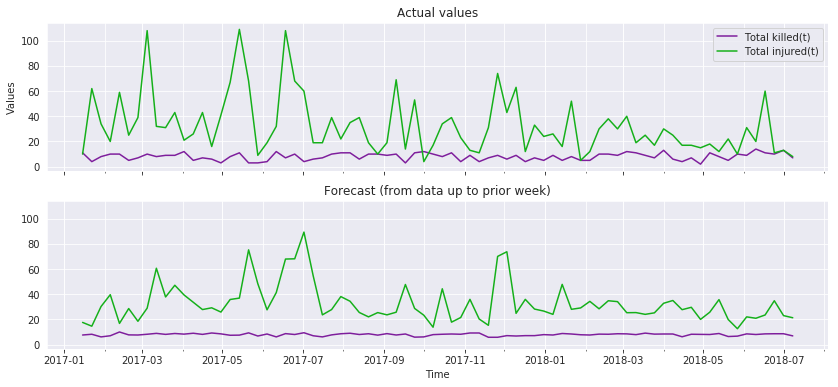

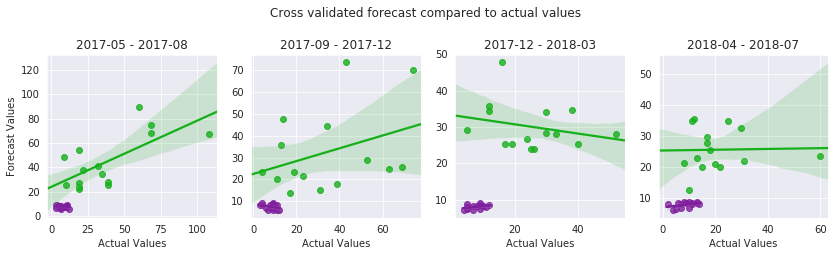

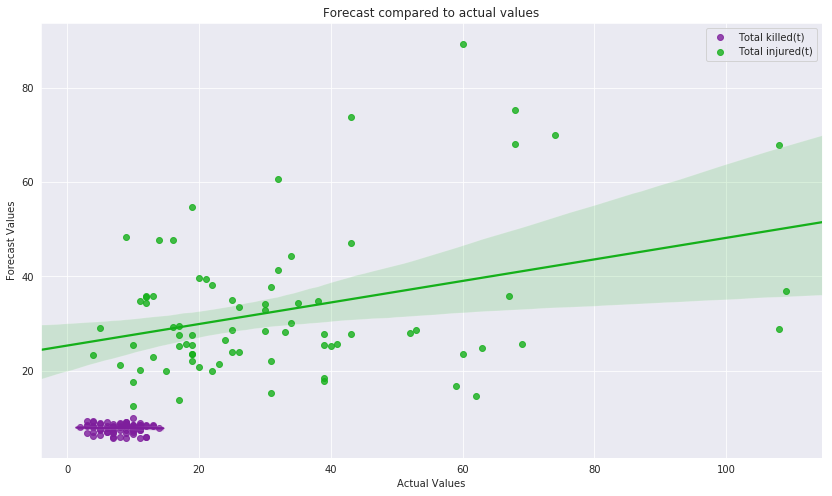

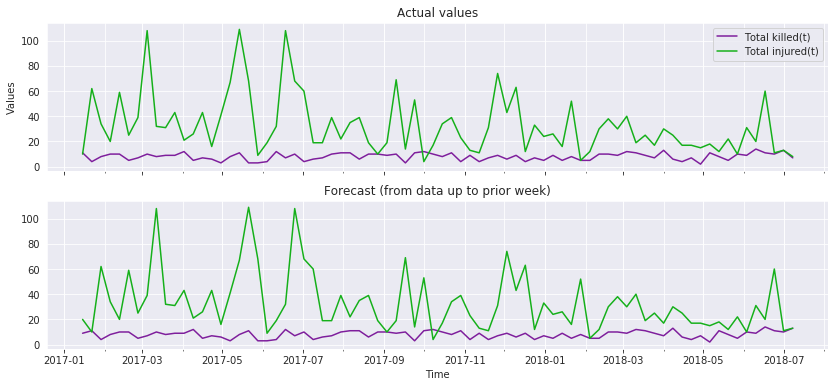

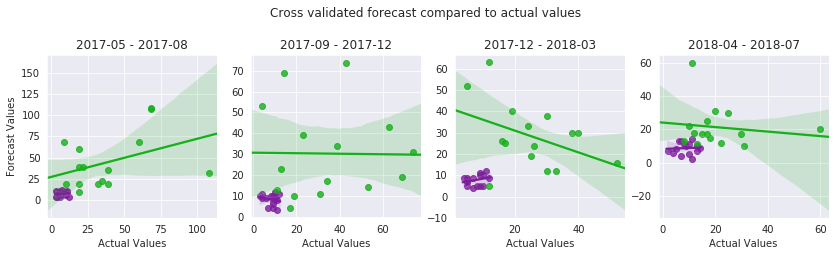

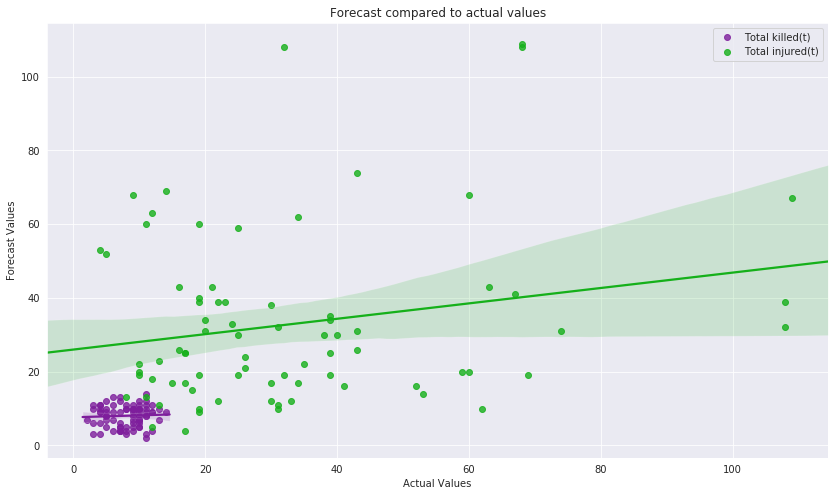

R_2:			 [-0.13278756  0.02184334]
Explained Variance:	 [-0.13185101  0.02189586]
Mean Squared Error:	 [  3.03196644  22.74456261]

Cross Validation:


Q1                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.242264          -0.229351                3.400196   
Total injured(t)  0.400057           0.467325               20.546468   

                        Q2                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.573236          -0.526399                3.361448   
Total injured(t) -0.112321          -0.108306               22.858784   

                        Q3                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)   0.111244           0.131514                2.295503   
Total injured(t) -0.680743          -0.520070               15.546168   

                        Q4                                             
                       r_2 explained_variance root_mean_squared_error  
Total killed(t)   0.095788           0.148438                3.232440  
Total injured(t) -0.414676          -0.251551               14.822573

In [16]:
#Train and test a given model

#import modules
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
#from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import Imputer
#from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import check_cv
from sklearn.metrics import confusion_matrix
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor 
import matplotlib.dates as mdates

#create imputer for nan values - this module can be used to replace missing values
#with something that won't cause an error
imp = Imputer(missing_values='NaN', strategy = 'mean')


def plot_model(y_test, y_pred):
    '''Function to visualize what the model is doing to assist in evaluation'''
    #module for placing tick locations by month
    months = mdates.MonthLocator()  
    
    #put the predictions and desired values in a dataframe next to each other
    sync = pd.DataFrame(y_pred, index=y_test.index)
    
    #set style and colors
    sns.set_style('darkgrid')
    sns.set_palette(catpal)
    
    #1. plot predictions vs. ground truth in a time series
    
    #create subplots
    f, ax = plt.subplots(2,1, figsize=(14,6), sharex=True)
        
    #plot the input values - removed
    #ax[0].plot(X_test.sort_index())
    #ax[0].set_title('Test Input (previous weeks)')
    
    #plot the actual values
    ax[0].plot(y_test.sort_index(), )
    ax[0].set_title('Actual values')
    
    #plot the predictions
    ax[1].plot(sync.sort_index())
    ax[1].set_title("Forecast (from data up to prior week)")
    
    #label and show the plots 
    ax[1].set_ylim(ax[0].get_ylim())
    ax[1].set_xlabel('Time')
    ax[0].set_ylabel('Values')
    
    for x in range(2):
        ax[x].xaxis.set_minor_locator(months)
        ax[x].tick_params(which="both", bottom=True)
        ax[x].grid(which='minor')
    ax[0].legend(labels=y_test.columns)
    plt.rcParams.update({'font.size': 10})
    plt.show()
    
    
    #Plot cross validations - scatterplots of predictions v. actual values in 4 different time ranges 
    f, ax = plt.subplots(1,4, figsize=(14,3), sharey=False)
    qsplit = TimeSeriesSplit(n_splits=4)
    frm = '%Y-%m'
    x=0
    for _, test_index in qsplit.split(y_test):
        for var in range(y_test.shape[1]):
            sns.regplot(y_test.iloc[test_index,var], sync.iloc[test_index,var], ax=ax[x], color=catpal[var], label=y_test.columns[var])
        idx = y_test.iloc[test_index,:].index.strftime(frm)
        datestr = str(idx[0]) + ' - ' + str(idx[-1])
        ax[x].set_title(datestr)
        ax[x].set_xlabel('Actual Values')
        ax[x].set_ylabel('')
        x += 1
    
    #show the plot
    f.suptitle('Cross validated forecast compared to actual values', y=1.1)
    ax[0].set_ylabel('Forecast Values')
    plt.show()
    
    #plot a comparison of the actual values next to the predictions overall
    f, ax = plt.subplots(figsize=(14,8))

    for var in range(y_test.shape[1]):
        sns.regplot(y_test.iloc[:,var], sync.iloc[:,var], ax=ax, label=y_test.columns[var])
    ax.set_title('Forecast compared to actual values')
    ax.set_ylabel('Forecast Values')
    ax.set_xlabel('Actual Values')
    
    if y_test.shape[1] < 15:
        ax.legend(bbox_to_anchor=(1,1))
    
    #show the plot
    plt.show()

def test_model(X_train, X_test, y_train, model):
    '''Function to make predicitons using the model based on training input'''
    
    #impute any NaN values
    imp.fit_transform(X_train, y_train)
    
    #fit the model to the training set
    model.fit(X_train, y_train)

    #predict outcomes based on training set
    y_pred = model.predict(X_test)
    
    #bandaid to set negative predictions to 0
    np.clip(y_pred, a_min=0, a_max=None, out=y_pred)
    
    #return the predictions and trained model
    return y_pred, model 

def get_coefs(X_train, y_train, model):
    '''get an array of coefficents or feature importances from the model'''
    #create an empty array (no. output features * no. input features)     
    coefs = np.empty((y_train.shape[1], X_train.shape[1]))
    
    #first try looping through and getting the feature coefs for every estimator - for MultiOutputRegressor
    try:
        for n in range(len(model.estimators_)):
            coefs[n] = model.estimators_[n].coef_
            #get a list of feature names and coefs here in a loop and combine?
    except:
        try: #if that throws an error just export the coef_ array directly from the model    
            coefs = model.coef_#np.empty(y_pred.shape)
        except:
            try: #if that throws an error we are probably using RandomForrest, and we just need the importances
                print('unable to fetch coefs, trying importance...')
                coefs = model.feature_importances_
                
            except: #if that throws an error we failed and we need to admit it
                print('Failed!')
    
    #return the coefficent array 
    return coefs


def score_model(y_test, y_pred, verbose=False):
    '''fuction to score the model according to several metrics and return those metrics'''
    
    #impute any NaN values
    imp.fit_transform(y_test, y_pred)
    
    #score models
    r_2 = r2_score(y_test.astype(float), y_pred.astype(float), multioutput='raw_values')
    ev = explained_variance_score(y_test.astype(float), y_pred.astype(float), multioutput='raw_values')
    rmse = np.sqrt(mean_squared_error(y_test.astype(float), y_pred.astype(float), multioutput='raw_values'))
       
    if verbose > 0:
        #Plot what these look like with fuction above if asked to
        plot_model(y_test, y_pred)
    
    #return train_score, test_score, r_2, ev, rmse, coefs, 
    return r_2, ev, rmse
    
def cv_score(y_test, y_pred):
    '''crossvalidate scores for continuiously trained time series'''
   
    #define varables for data frames - Note: these are not litterally yearly quarters. They don't line up that way
    qlist = ['Q1','Q2','Q3','Q4']
    vlist = ['r_2','explained_variance','root_mean_squared_error']
    cv = {}
    
    #instantiate time series splitter
    qsplit = TimeSeriesSplit(n_splits=4)
    
    #loop through splits and save scores to dataframe
    x=0
    for _, test_index in qsplit.split(y_test):
        r_2, ev, rmse = score_model(y_test.iloc[test_index], y_pred.iloc[test_index])
        scores = pd.DataFrame(index=y_test.columns, columns=vlist)
        scores.loc[:,'r_2'] = r_2
        scores.loc[:,'explained_variance'] = ev
        scores.loc[:,'root_mean_squared_error'] = rmse
        #save the dataframe in a dictionary
        cv[qlist[x]] = scores 
        x += 1
    
    #concat the dataframes together and return
    cv_df = pd.concat([cv['Q1'],cv['Q2'],cv['Q3'],cv['Q4']], axis=1, keys=cv.keys())
    return cv_df


def try_model(X, y, model, verbose=0, random_state=None):
    '''fuction to that takes a given model and a dataset, and evaluates the model
        -gives the option to plot relivant data
        -returns relivant scoring metrics'''

    #Split X and Y into training and testing sets using time series split. 
    #In this case X will consist of every week up until a given week in y,
    tscv = TimeSeriesSplit(n_splits=len(y)-1)
    
    #initialize data frames to fill with predictions and baseline scores
    y_pred = pd.DataFrame(index=y.index, columns=y.columns)
    y_control = y_pred.copy(deep=True)
    
    #A warm start adds training to a model rather than retraining it for new data.
    #to use one we have to increase the number of estimators with every run
    try: #first try getting the base no. of estimators from the model
        warm_start = model.get_params(deep=True)['n_estimators']
    except:#if that doesn't work just start with 0
        warm_start = 0
    
    #loop through every index of the time series split (every week)
    for train_index, test_index in tscv.split(X):
        
        #set training and testing values based on index.
        #Again X is every week before a given week in y.
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        #If model is using a warm start, set number of estimators based on
        #how many runs we've done, and change training set to a sliding window for efficency
        try:
            if model.get_params(deep=True)['warm_start'] == True:
                model.set_params(n_estimators=warm_start) 
                X_train, y_train = X_train[-16:], y_train[-16:]
        except: #if that doesn't work forget it
            pass
        
        y_control.iloc[test_index] = y.iloc[test_index-1].values
        
        #use functions above to train model and create predictions_
        try:
            y_pred.iloc[test_index], model = test_model(X_train, X_test, y_train, model)
        except:
            pass  #handle exception to return data up to any failure point
            
        warm_start+=10
        #debug logging
        
        if test_index.sum() < 0:
            print('\nRun:\t',test_index)
            print('X_train:\t', X_train.iloc[:,:2])
            print('y_train:\t', y_train.iloc[:,:2])
            print('X_test:\t', X_test.iloc[:,:2])
            print('y_pred:\t', y_pred.iloc[test_index])
            print('y_test:\t', y_test.iloc[:,:2])
            print('y_control:\t', y_control.iloc[test_index])
    
    y_test = y #for better plotting
    
    #return train/test split, predicitons and control - with front two datapoints chopped off 
    return X_train[2:], X_test[2:], y_train[2:], y_test[2:], y_pred[2:], y_control[2:].fillna(0)
    #lets not chop them off anymore
    #return X_train, X_test, y_train, y_test, y_pred, y_control.fillna(0) 
    
#define y - we'll just predict two variables for the dry run
y = y_week.loc[:,['Total killed(t)','Total injured(t)']] 

#instantiate a model to feed through the core functions
model = RandomForestRegressor(random_state=56)

#give the functions to try a given model a dry run to see if it works.
print('Dry Run:')

#try the model
X_train, X_test, y_train, y_test, y_pred, y_control = try_model(X_week, y, model, verbose = 2, random_state=56)
#score the model
dry_scores = score_model(y_test, y_pred, verbose=True)

#find and show the baseline scores - assuming one week will continue as the next
control_scores = score_model(y_test, y_control, verbose=True)

#find and plot the crossvalidated scores

#print summary scores
dry_cv = cv_score(y_test, y_pred)
print('R_2:\t\t\t',dry_scores[0])
print('Explained Variance:\t', dry_scores[1])
print('Mean Squared Error:\t', dry_scores[2])
print('\nCross Validation:')

dry_cv

The visualization above is the output of a "dry run" of one model, with a prediction of two variables to ensure the core functions are working correctly. 

Ideally trends in the forecast for a given week or month, should line up with the trends in the actual values for that week. There appears to be a tendency of the forecast to lag behind trends in actual values, but in a few examples of the dry run the peaks and valleys in the trend and the forecast seem to match perfectly. This could be the result of random variation, but may also indicate the presence of leading indicators. 

In the scatter plot comparing actual values to forecast values, a line closer to 45 degrees and indicates more of the variation in values are explained in the model, and the more closely the dots are to a given line, the smaller the error is.  These scores are indicated numerically by Root Mean Squared Error (standard deviation of the error), explained variance (how much of the variance in the forecast is explained by the model) and R^2(which is a bit like mix of both).  In a final product on Nepal Monitor, Root Mean Squared Error could be transformed into margin of error or confidence interval to indicate the accuracy of the prediction

Dry Run:


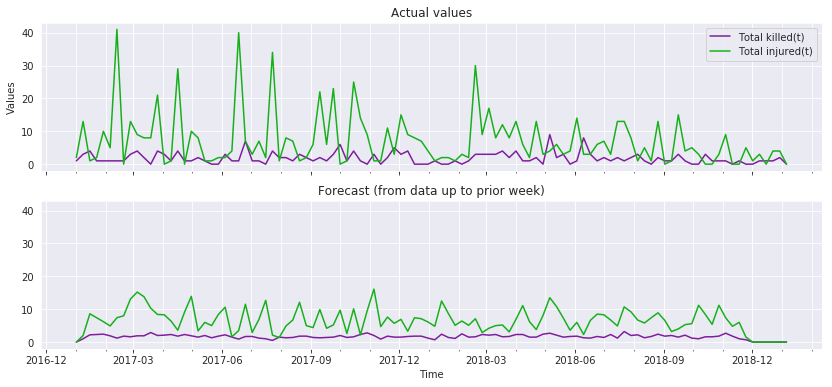

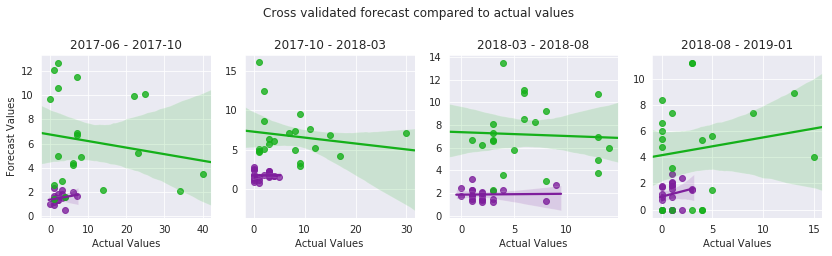

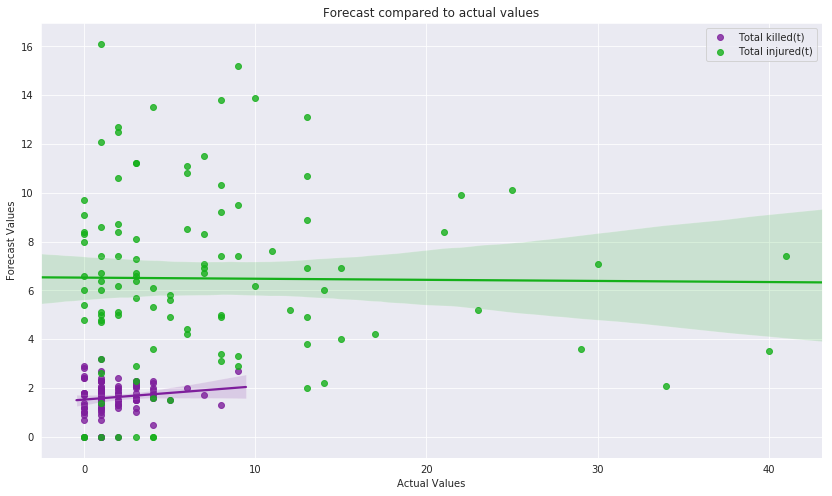

R_2:			 [-0.04843044 -0.2043495 ]
Explained Variance:	 [-0.03756372 -0.19682051]
Mean Squared Error:	 [ 1.74209806  9.06808627]

Cross Validation:


Q1                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.125537           0.056075                1.849324   
Total injured(t) -0.339829          -0.213555               13.153598   

                        Q2                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.087843          -0.087631                1.707546   
Total injured(t) -0.345278          -0.336513                8.023596   

                        Q3                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.082389          -0.039581                2.322663   
Total injured(t) -0.545628          -0.526107                5.127006   

                        Q4                                             
                       r_2 explained_variance root_mean_squared_error  
Total killed(t)  -0.602725          -0.535281                1.137457  
Total injured(t) -0.595994          -0.507985                5.252074

In [11]:
def try_model_province(X, y, model, verbose=0, random_state=None):
    '''fuction to that takes a given model and a dataset, and evaluates the model
        -gives the option to plot relivant data
        -returns relivant scoring metrics'''

    #Split X and Y into training and testing sets < - try modifying these functions for 'sliding window'
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, shuffle=False, random_state=random_state)
   
    
    
    #idx = 0
    y_pred = pd.DataFrame(index=y.index, columns=y.columns)
    y_control = pd.DataFrame(index=y.index, columns=y.columns)#np.empty_like(y) 
    #add loop here to make it iterative by week
   
    warm_start=10
    for week in range(99):
        for pro in range(1,8):
            province = 'province '+str(pro)
            X_prov, y_prov = X.loc[province], y.loc[province] 
            tscv = TimeSeriesSplit(n_splits=int(len(y_prov)-1))
            index = list(tscv.split(X.loc[province])) #change this so it doesn't go all the way through
            train_index, test_index = index[week]
            X_train, X_test = X_prov.iloc[train_index], X_prov.iloc[test_index]
            y_train, y_test = y_prov.iloc[train_index], y_prov.iloc[test_index]
            
            #if model is using a warm start, set number of parameters based on
            #how many runs we've done, and change training set to a sliding window
            try:
                if model.get_params(deep=True)['warm_start'] == True:
                    model.set_params(n_estimators=warm_start) 
                    X_train, y_train = X_train[-16:], y_train[-16:]
            except:
                pass
                
            y_pred.loc[(province,),].iloc[test_index], model\
            = test_model(X_train, X_test, y_train, model)
            #model.fit(X_train.loc[(province,),:], y_train.loc[(province,),:])
            warm_start += 2
            
            #debug logging
            y_control.iloc[test_index] = y.iloc[test_index-1]
            if test_index.sum() < 0:
                print('\nRun:\t',test_index)
                print(province+':')
                print('X_train:\t', X_train.iloc[:,:2])
                print('y_train:\t', y_train.iloc[:,:2])
                print('X_test:\t', X_test.iloc[:,:2])
                print('y_pred:\t', y_pred.loc[province].iloc[test_index])
                print('y_test:\t', y_test.iloc[:,:2])
    
    y_test = y #for better plotting
    
    #return train/test split, predicitons and control - with front two datapoints chopped off 
    return X_train[2:], X_test[2:], y_train[2:], y_test[2:], y_pred[2:], y_control[2:].fillna(0) 

#trying a dry run with provinces
#define y
y = y_province.loc[:,['Total killed(t)','Total injured(t)']] # > in_week.loc[:,'Total killed'].quantile(.5)      

model = RandomForestRegressor(random_state=56, warm_start=False)

print('Dry Run:')
#give the function to try a given model a dry run to see if it works.
X_train, X_test, y_train, y_test, y_pred, y_control = try_model_province(X_province, y, model, verbose = 2, random_state=56)
dry_scores = score_model(y_test.loc['province 2'], y_pred.loc['province 2'].fillna(0), verbose=True)
dry_cv_prov = cv_score(y_test.loc['province 2'], y_pred.loc['province 2'].fillna(0))
print('R_2:\t\t\t',dry_scores[0])
print('Explained Variance:\t', dry_scores[1])
print('Mean Squared Error:\t', dry_scores[2])
print('\nCross Validation:')
#for x in ['Q1','Q2','Q3','Q4']:
#    print('\n',x)
#    print(dry_cv[x])
dry_cv_prov

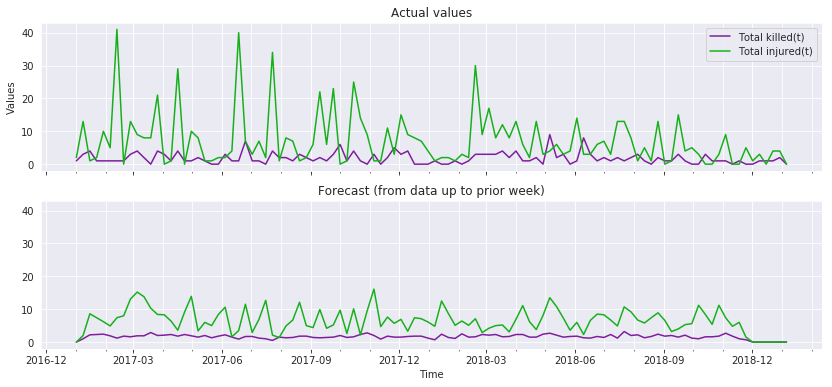

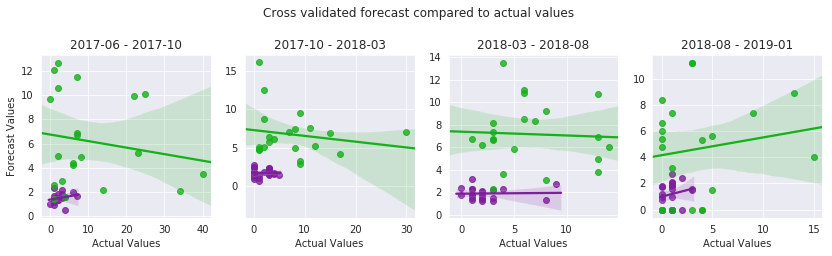

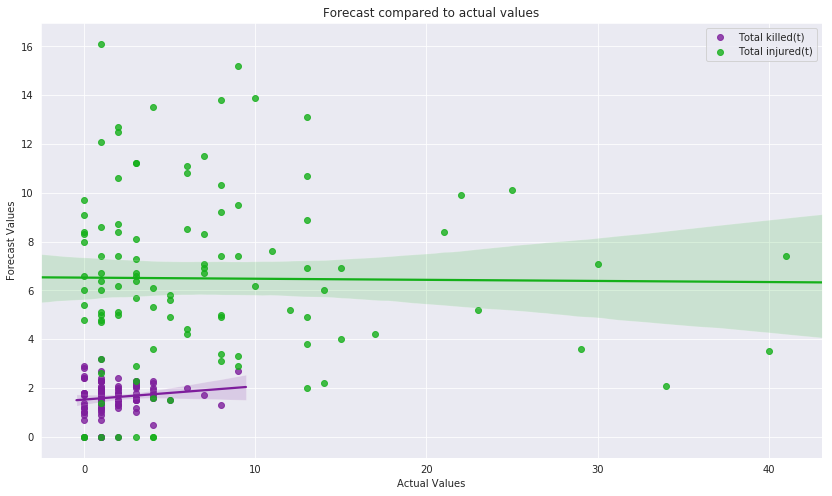

R_2:			 [-0.04843044 -0.2043495 ]
Explained Variance:	 [-0.03756372 -0.19682051]
Mean Squared Error:	 [ 1.74209806  9.06808627]

Cross Validation:


Q1                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.125537           0.056075                1.849324   
Total injured(t) -0.339829          -0.213555               13.153598   

                        Q2                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.087843          -0.087631                1.707546   
Total injured(t) -0.345278          -0.336513                8.023596   

                        Q3                                             \
                       r_2 explained_variance root_mean_squared_error   
Total killed(t)  -0.082389          -0.039581                2.322663   
Total injured(t) -0.545628          -0.526107                5.127006   

                        Q4                                             
                       r_2 explained_variance root_mean_squared_error  
Total killed(t)  -0.602725          -0.535281                1.137457  
Total injured(t) -0.595994          -0.507985                5.252074

In [12]:
province = 'province 2'
dry_scores = score_model(y_test.loc[province], y_pred.loc[province].fillna(0), verbose=True)
dry_cv_prov = cv_score(y_test.loc[province], y_pred.loc[province].fillna(0))
print('R_2:\t\t\t',dry_scores[0])
print('Explained Variance:\t', dry_scores[1])
print('Mean Squared Error:\t', dry_scores[2])
print('\nCross Validation:')
#for x in ['Q1','Q2','Q3','Q4']:
#    print('\n',x)
#    print(dry_cv[x])
dry_cv_prov

In [13]:
y_test

Total killed(t)  Total injured(t)
Province   Event Date                                   
province 1 2017-01-15              0.0               0.0
           2017-01-22              2.0               3.0
           2017-01-29              4.0               3.0
           2017-02-05              2.0               3.0
           2017-02-12              3.0               5.0
           2017-02-19              0.0               2.0
           2017-02-26              1.0               1.0
           2017-03-05              2.0              45.0
           2017-03-12              0.0               1.0
           2017-03-19              4.0               4.0
           2017-03-26              2.0               0.0
           2017-04-02              1.0               1.0
           2017-04-09              1.0               5.0
           2017-04-16              0.0              11.0
           2017-04-23              2.0               2.0
           2017-04-30              1.0               9.0
           2017-05-07              2.0               7.0
           2017-05-14              3.0               2.0
           2017-05-21              0.0               3.0
           2017-05-28              0.0               2.0
           2017-06-04              1.0               9.0
           2017-06-11              6.0               5.0
           2017-06-18              1.0               1.0
           2017-06-25              2.0               9.0
           2017-07-02              0.0              11.0
           2017-07-09              1.0               5.0
           2017-07-16              2.0               3.0
           2017-07-23              1.0               0.0
           2017-07-30              1.0               2.0
           2017-08-06              2.0               5.0
...                                ...               ...
province 7 2018-06-10              0.0               2.0
           2018-06-17              0.0              12.0
           2018-06-24              1.0               0.0
           2018-07-01              2.0               0.0
           2018-07-08              1.0               0.0
           2018-07-15              1.0               4.0
           2018-07-22              2.0               2.0
           2018-07-29              1.0               0.0
           2018-08-05              1.0               1.0
           2018-08-12              0.0               0.0
           2018-08-19              0.0               1.0
           2018-08-26              2.0              12.0
           2018-09-02              0.0               0.0
           2018-09-09              1.0               0.0
           2018-09-16              3.0               0.0
           2018-09-23              2.0               4.0
           2018-09-30              0.0               1.0
           2018-10-07              0.0               2.0
           2018-10-14              0.0               0.0
           2018-10-21              0.0               0.0
           2018-10-28              0.0               0.0
           2018-11-04              0.0               0.0
           2018-11-11              0.0               0.0
           2018-11-18              1.0               0.0
           2018-11-25              0.0               0.0
           2018-12-02              0.0               0.0
           2018-12-09              0.0               0.0
           2018-12-16              0.0               0.0
           2018-12-23              0.0               0.0
           2018-12-30              1.0               1.0

[735 rows x 2 columns]

In [14]:
y_pred.loc[('province 1',),:]

,Total killed(t),Total injured(t)
Event Date,,
2017-01-15,1.6,3.2
2017-01-22,1.3,2.6
2017-01-29,1.2,2.2
2017-02-05,2.1,2.2
2017-02-12,2.3,3
2017-02-19,2.3,3.2
2017-02-26,1.8,3.2
2017-03-05,2,2.7
2017-03-12,1.7,19.2


### Find variables with the best prediction scores

In [55]:
def interpret_coefs(coefs, X_train, cats):
    '''plot histograms of the coefficients as well and bar charts of the top coefficients'''
    
    #plot histogram of coefficents for each out variable  
    for cat in range(len(cats)):
        try:
            sns.distplot(coefs[cat], color=catpal[cat], label=cats[cat])#.sort_values(1))
            print('plotting', cats[cat])
            plt.xlabel('feature coefficient', fontsize='x-large')
        except:
            pass
            #print("couldn't plot ", cats[cat])
    try:
        sns.distplot(coefs)
        plt.xlabel('feature importance', fontsize='x-large')
        
    except:
        pass
    
    #plot top coefficnts for each variable - currently doesn't do it, plotting top for one. 
    plt.legend(bbox_to_anchor=(1,1))
    plt.ylabel('density at given value', fontsize='x-large')
    plt.rcParams.update({'font.size': 13})
    plt.show()
    
    #creat a dataframe of coefiecents and their feature labels by output
    print('Total feature coefs:', coefs.shape)
    if coefs.shape[0] > 1:
        coefframe = pd.DataFrame(coefs, index=X_train.columns)
    else:
        coefframe = pd.DataFrame(coefs, columns=cats, index=X_train.columns)
        
    #coefframe = coefframe.transpose()
    try:
        serieslist = []
        for cat in cats:
            serieslist.append(coefframe.loc[:,cat].nlargest(5))
            data = concat(serieslist, axis=1)
            print('Top feature coefs:\n', data.head())
    except:
        data=coefframe.nlargest(10, coefframe.columns)
        print('\nTop feature coefs:\n', data.head())
    n=0
    for cat in data.columns: 
        sns.swarmplot(y=data.index, x=cat, data=data, color=catpal[n], alpha=.5, size=10)
        n += 1
        
        #plt.legend()
    plt.ylabel('input category', fontsize='x-large')
    plt.xlabel('coef / importance', fontsize='x-large')
    plt.legend()
    plt.show()
    return coefframe


Finding Variables...

top score r_2: 0.26241020821170424
top score explained variance: 0.302341013752
best score rmse: 0.42832410446

control test - forcast using exact values of previous week:
top score r_2: 0.402915094814
top score explained variance: 0.402915094814
best score rmse: 0.554700196225

Top Scoring Variables:


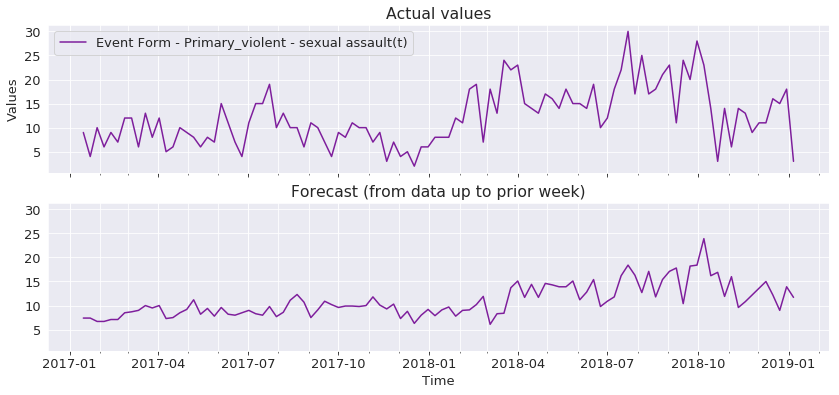

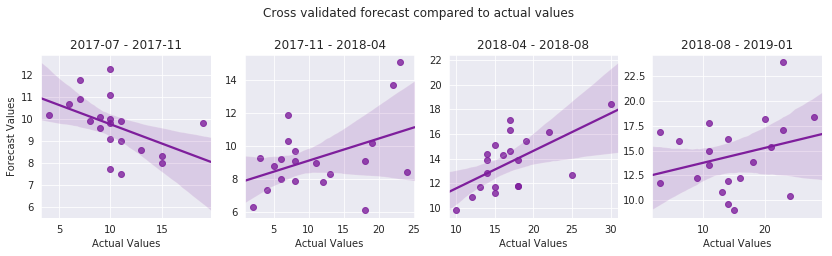

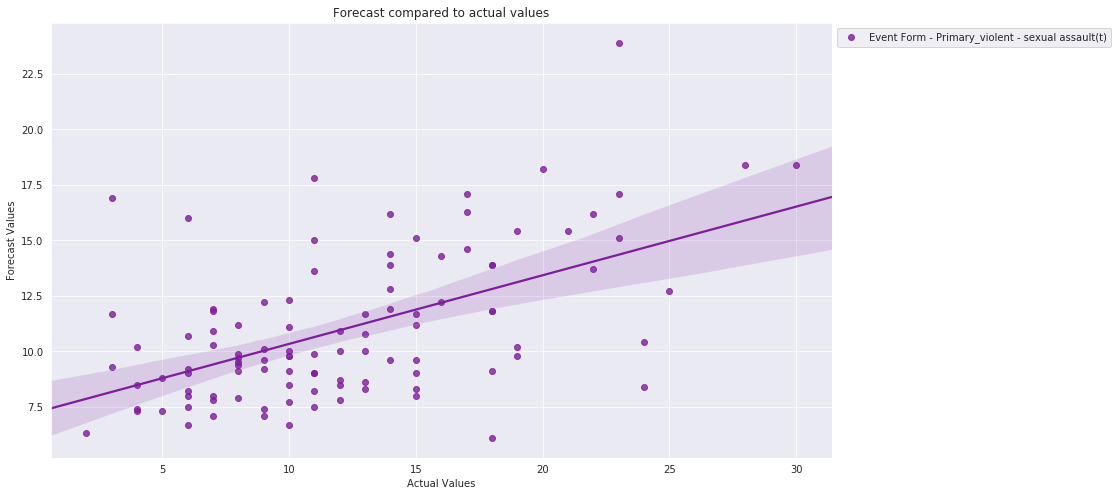

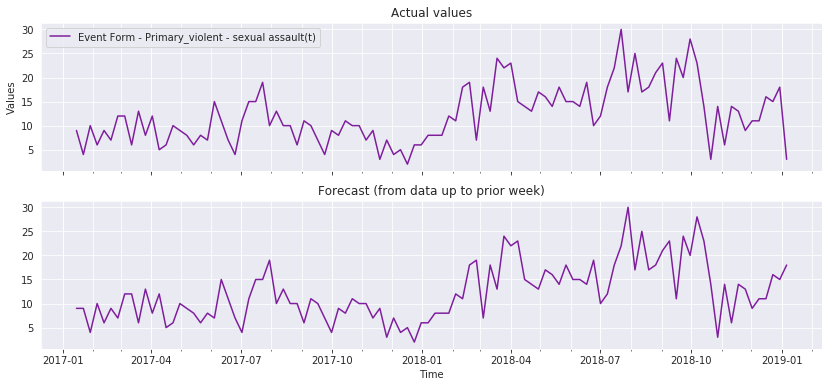

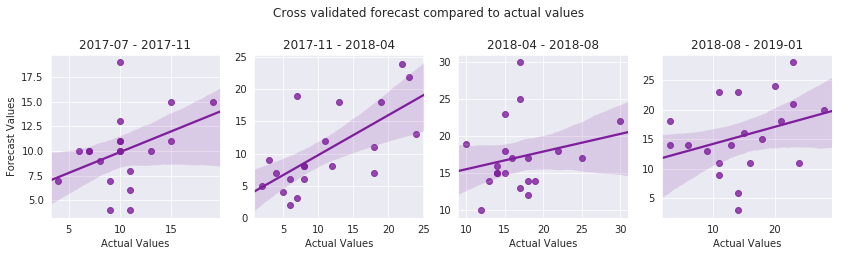

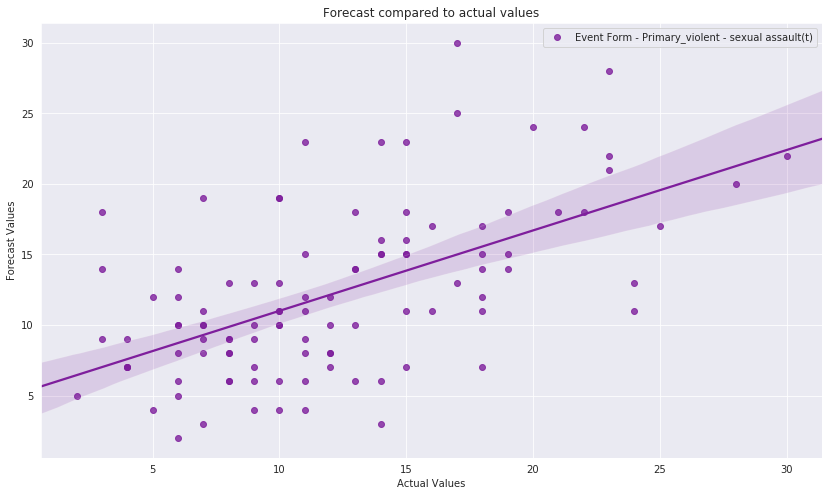

unable to fetch coefs, trying importance...


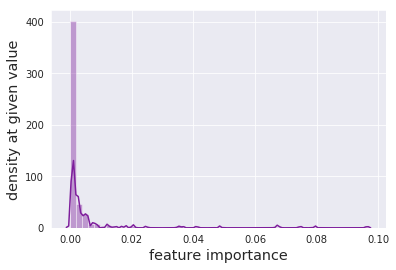

Total feature coefs: (321,)

Top feature coefs:
                                                            0
Collective / Interpersonal_collective(t-001)        0.096349
Actor 1 - Affiliation_unclear(t-001)                0.079536
Cause - Primary_political - contestation over c...  0.074663
Event Form - Secondary_nonviolent - arrest (t-001)  0.067630
Actor 2 - Target_political organization/politic...  0.067081


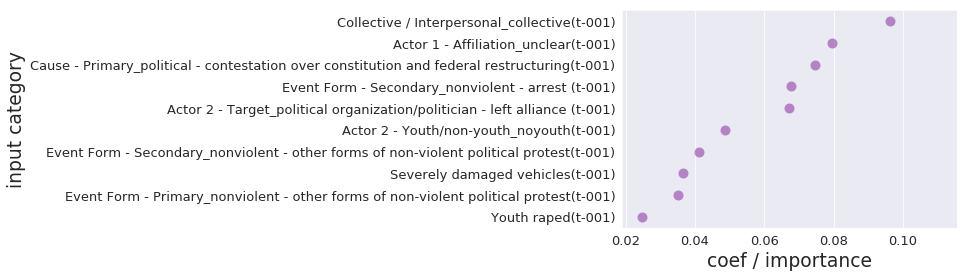

scores  \
                                                         r_2   
Event Form - Primary_violent - sexual assault(t)     0.26241   
Actor 1 - Youth/non-youth_unknown(t)                0.251101   
Collective / Interpersonal_collective(t)            0.214787   
Cause - Primary_political - election-related in...  0.196403   
Actor 2 - Youth/non-youth_unknown(t)                0.189529   
Total raped(t)                                      0.182729   
Weapons_improvised explosive device (t)             0.170281   
Female raped(t)                                     0.159909   
Onesided / Twosided_onesided(t)                     0.138751   
Collective / Interpersonal_interpersonal(t)         0.133687   

                                                                       \
                                                   explained_variance   
Event Form - Primary_violent - sexual assault(t)             0.302341   
Actor 1 - Youth/non-youth_unknown(t)                         0.272574   
Collective / Interpersonal_collective(t)                     0.234222   
Cause - Primary_political - election-related in...           0.197157   
Actor 2 - Youth/non-youth_unknown(t)                         0.195436   
Total raped(t)                                               0.243311   
Weapons_improvised explosive device (t)                      0.170282   
Female raped(t)                                              0.213411   
Onesided / Twosided_onesided(t)                              0.143717   
Collective / Interpersonal_interpersonal(t)                  0.135771   

                                                                            \
                                                   root_mean_squared_error   
Event Form - Primary_violent - sexual assault(t)                   5.10372   
Actor 1 - Youth/non-youth_unknown(t)                               20.5448   
Collective / Interpersonal_collective(t)                           24.5022   
Cause - Primary_political - election-related in...                 24.7044   
Actor 2 - Youth/non-youth_unknown(t)                                 8.909   
Total raped(t)                                                     5.28336   
Weapons_improvised explosive device (t)                            11.8056   
Female raped(t)                                                    5.18185   
Onesided / Twosided_onesided(t)                                    16.4746   
Collective / Interpersonal_interpersonal(t)                        8.88097   

                                                   control_scores  \
                                                              r_2   
Event Form - Primary_violent - sexual assault(t)          0.15976   
Actor 1 - Youth/non-youth_unknown(t)                     0.012414   
Collective / Interpersonal_collective(t)                0.0280466   
Cause - Primary_political - election-related in...       0.055514   
Actor 2 - Youth/non-youth_unknown(t)                    -0.359472   
Total raped(t)                                         -0.0101023   
Weapons_improvised explosive device (t)                 0.0283659   
Female raped(t)                                        -0.0162102   
Onesided / Twosided_onesided(t)                         -0.142361   
Collective / Interpersonal_interpersonal(t)             0.0203266   

                                                                       \
                                                   explained_variance   
Event Form - Primary_violent - sexual assault(t)             0.159854   
Actor 1 - Youth/non-youth_unknown(t)                        0.0126509   
Collective / Interpersonal_collective(t)                    0.0281704   
Cause - Primary_political - election-related in...           0.055514   
Actor 2 - Youth/non-youth_unknown(t)                        -0.359412   
Total raped(t)                                              -0.010059   
Weapons_improvised explosive device (t)                   

In [56]:
#find which variables have the best scores
from sklearn.linear_model import ARDRegression

def find_var (X, df, model, n_true, verbose=False, random_state=None, s_plot=0, n_plot=1, province=''):
   
    #filter out varables where the perentage "true" is less than n_true, to avoid completely unbalanced data
    pc_true = [sum(df[x] >= 1)/len(df[x])*100 > n_true for x in df.columns]
    y = df.loc[:,pc_true] 
    
    if province != '':  
        X_train, X_test, y_train, y_test, y_pred, y_control = try_model_province(X, y, model, verbose=False)
        y_test = y_test.loc[province].dropna()
        y_pred = y_pred.loc[province].fillna(0)
        y_control = y_control.loc[province].fillna(0)
    
    else:
        X_train, X_test, y_train, y_test, y_pred, y_control = try_model(X, y, model, verbose=False)
    
    
    #score the model
    r_2, ev, rmse = score_model(y_test, y_pred, verbose=False)
    
    #Score the model based on control (simply continuing the values from the previous week). 
    r_2_c, ev_c, rmse_c, = score_model(y_test, y_control, verbose=False)
    
    
    #save all these scores in data frames
    collist = ['r_2','explained_variance','root_mean_squared_error']    
    scores = pd.DataFrame(index=df.columns, columns=(collist))
    scores_c = pd.DataFrame(index=df.columns, columns=(collist))
    
    scores.loc[pc_true,'r_2'] = r_2
    scores.loc[pc_true,'explained_variance'] = ev
    scores.loc[pc_true,'root_mean_squared_error'] = rmse

    scores_c.loc[pc_true,'r_2'] = r_2_c
    scores_c.loc[pc_true,'explained_variance'] = ev_c
    scores_c.loc[pc_true,'root_mean_squared_error'] = rmse_c
    
    #crossvalidate quarterly periods
    cv_scores = cv_score(y_test, y_pred)
    
    #calculate cv means
    cv_mean = pd.DataFrame(index=cv_scores.index)
    #cv_mean.set_columns(['cv_mean',collist],inplace=True)
    for x in range(3):
        col = collist[x]
        cv_mean.loc[:,col] = [cv_scores.iloc[y,x::3].agg('mean') for y in range(len(cv_scores))]
    
    if verbose > 1:
        #print scores
        #print('total train score:', train_score )
        #print('total test score:', test_score)
        print('\ntop score r_2:',scores['r_2'].max())
        print('top score explained variance:',ev.max())
        print('best score rmse:',rmse.min()) 
        
        print('\ncontrol test - forcast using exact values of previous week:')
        print('top score r_2:',r_2_c.max())
        print('top score explained variance:',ev_c.max())
        print('best score rmse:',rmse_c.min())
    
    #add crossvalidated scores to dataframe
    
    cv_mean.columns = pd.MultiIndex.from_product([['cv_mean'],collist])
    scores.columns = pd.MultiIndex.from_product([['scores'],collist])
    scores_c.columns = pd.MultiIndex.from_product([['control_scores'],collist])
    
    scores = pd.concat([scores, scores_c, cv_mean, cv_scores], axis=1)    
    #find best crossvalidation scores? - maybe after draft presentation    
    
    #filter out explained variance scores below 
    top = scores.loc[scores[('scores','explained_variance')] > -1].sort_values(('scores','r_2'), ascending=False)
    
    #filter out scores that don't beat the control - (errors are higher than control)
    worse = top.loc[top[('scores','root_mean_squared_error')] > top[('control_scores','root_mean_squared_error')]]
    top.drop(worse.index, inplace=True)
    
    #find differences between model and control in R_2
    diff = (top[('scores','r_2')] - top[('control_scores','r_2')])#.sort_values(ascending=False)
    
    #filter out low differences with control
    top = top.loc[diff > .1]
    
    
    if verbose > 0:
        #plot what the best scores look like. 
        print("\nTop Scoring Variables:")
        yfilt = [ x in top[s_plot:n_plot].index.tolist() for x in y_test.columns]
        plot_model(y_test.loc[:,yfilt], y_pred.loc[:,yfilt])
    
    if verbose > 1:
    #plot what the control scores look like
        #print(y_control)
        plot_model(y_test.loc[:,yfilt], y_control.loc[:,yfilt])
    
    #top_scores = score_model(X_train, X, y_train.loc[:,top.index[:3]], y.loc[:,top.index[:3]], y_pred.loc[:,top.index[:3]], model, verbose=verbose)
    #top_scores = find_var(X_week, y_week.loc[:,better.index[:3]], model, n_true=20, verbose=2, random_state=38)
    return scores, top

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)
#for step in range(5,y_week.shape[1])[::5]:
    #model = MultiOutputRegressor(ARDRegression(), n_jobs=-1)
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    #model = LinearRegression()
    model = RandomForestRegressor(random_state=56, warm_start=False)
    
    print("Finding Variables...")
    scores, top = find_var(X_week, y_week, model, n_true=20, verbose=2, n_plot=1)
    #get feature coeficents and feature importance
    coefs = get_coefs(X_train, y_train, model)
    coefframe = interpret_coefs(coefs,X_train,top.index)
    
    #print top 10 scores that beat control
top[:10]
    

The model is doing well when asked to predict everything from everything, loses effectiveness when asked to predict a narrow set of variables.  May have to change how scoring / plot works. Luckily it seems to do significantly better than control (assuming value will be the same as the previous week). Perhaps use classifier to predict increase or decrease is an option.

In [57]:
coefframe.head()

,0
Total killed(t-001),0.007802
Female killed(t-001),0.003828
Youth killed(t-001),0.001201
Total injured(t-001),0.002535
Female injured(t-001),0.002787


In [23]:
#Optimize with Gridsearch / random search
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

def random_search(params, model, n_iter):
    #define splitter... time series split?
    qsplit = TimeSeriesSplit(n_splits=4)

    #instantiate grid search - use normal scoring function
    #Search = GridSearchCV(RandomForestRegressor(random_state=56), param_grid=params, cv=qsplit)
    Search = RandomizedSearchCV(model, param_distributions=params, cv=qsplit, n_jobs=-1, n_iter=n_iter)

    #fit X_week, Y_week
    Search.fit(X_week, y_week)

    #find the best scoring model
    best_params = Search.best_params_
    best_score = Search.best_score_
    #show the results
    results = Search.cv_results_
    #print('results:\n',results)
    #define param grid - get params from model - test first
    return best_params, best_score, results
 
model = RandomForestRegressor(random_state=56)    
params = {'n_estimators':range(150,300,1),
          'warm_start':[False],
          'max_depth':range(1,300,1),
          'min_samples_split':np.linspace(0.00000001,.1,100),
          'min_samples_leaf':range(5,6,1),
          'min_weight_fraction_leaf':np.linspace(.0000001,.1,100),
          'max_features':range(150,200,1),
          'max_leaf_nodes':range(180,300,1),
          'min_impurity_decrease':np.linspace(0.000001,.1,100)}

best_params, best_score, results = random_search(params, model, 20)
print('\nbest parameters',best_params)
print('best score',best_score)
#Next try plotting parameters next to resulting scores


best parameters {'warm_start': False, 'n_estimators': 279, 'min_weight_fraction_leaf': 0.036363700000000006, 'min_samples_split': 0.093939394545454552, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.033334000000000003, 'max_leaf_nodes': 193, 'max_features': 194, 'max_depth': 132}
best score -0.415385410379


plotting 9 params...


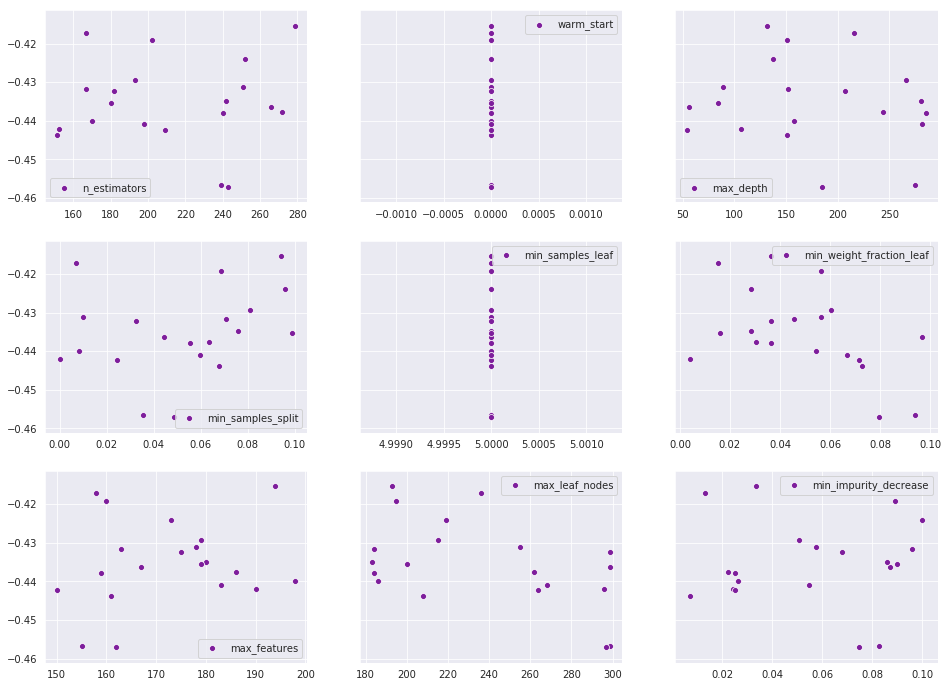

In [24]:
#Plot Results
def plot_params(params, results):
    plotlen = len(params.keys())
    plotht = int((plotlen+1)/3)
    print('plotting', plotlen, 'params...')
    f, ax = plt.subplots(plotht,3, figsize = (16,plotht*4), sharey=True)

    count = 0
    for key in params.keys():
        ax1 = int(count/3)
        ax2 = count%3
        try:
            sns.scatterplot(results['param_'+key],results['mean_test_score'], label=key, ax=ax[ax1][ax2])
        
        except:
            lst = []
            for item in results['param_'+key]:
                lst.append(item[0])
                #print(lst)
            sns.scatterplot(lst ,results['mean_test_score'], label=key)
        
        plt.legend(bbox_to_anchor=(1,1))
        count += 1
             
        #print(count, ax1, ax2)
    plt.show()
    
plot_params(params, results)

The results plot above is used to refine the parameter space of the random hyper parameter search in order to tune the model.  The parameter search trains and scores the model 100 times using randomly chosen parameters within the given parameter space. These parameters are then scatterplotted against the resulting score.  Downward trends on either end of a given parameter range can then be eliminated and fed back into the randomized search, until the scatterplots appear random. The resulting tuned parameters are then used for that model going forward

Finding Variables...

top score r_2: 0.3255608399592642
top score explained variance: 0.330747428284
best score rmse: 0.421925127144

control test - forcast using exact values of previous week:
top score r_2: 0.402915094814
top score explained variance: 0.402915094814
best score rmse: 0.554700196225

Top Scoring Variables:


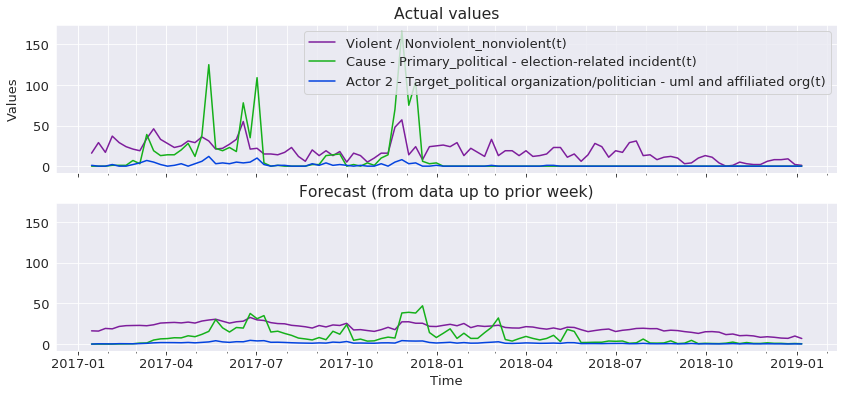

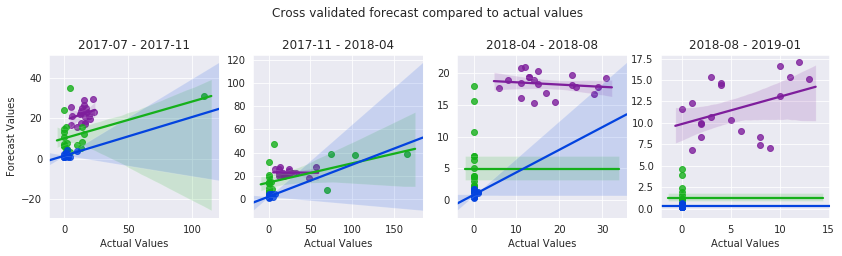

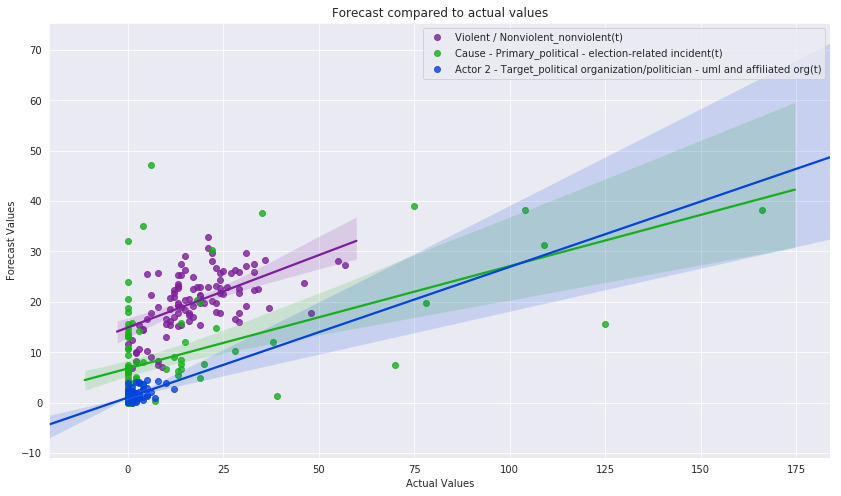

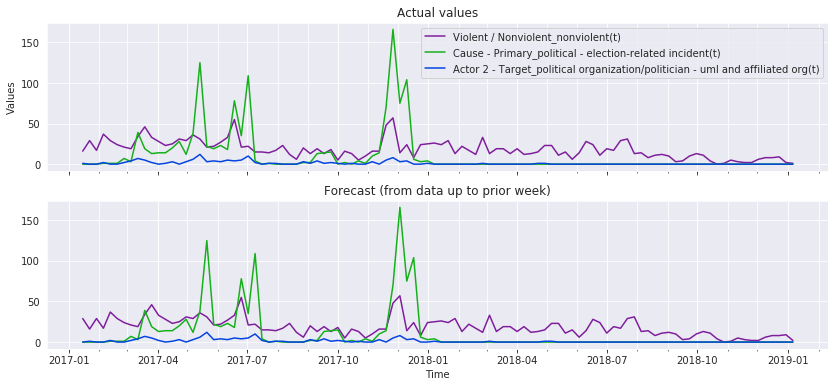

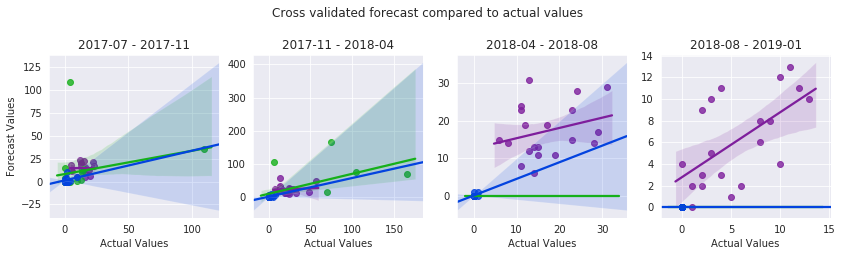

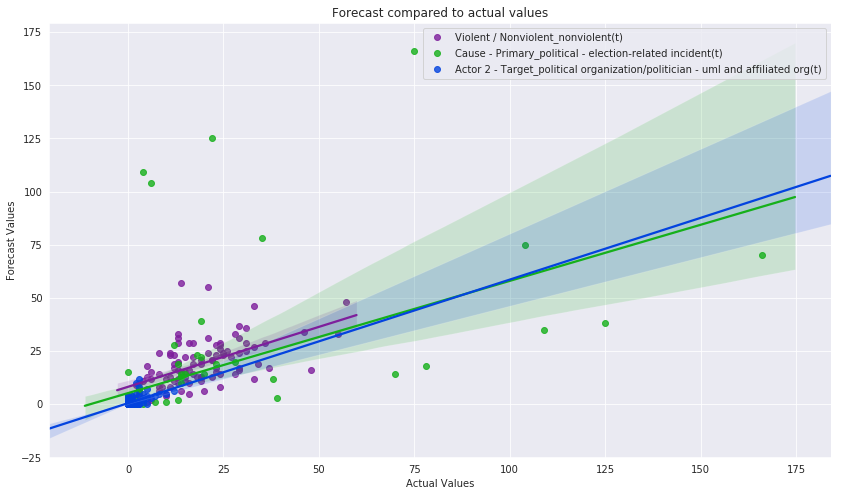

unable to fetch coefs, trying importance...


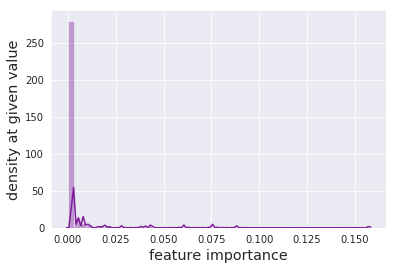

Total feature coefs: (321,)

Top feature coefs:
                                                            0
Event Form - Primary_nonviolent - other forms o...  0.157504
Collective / Interpersonal_collective(t-001)        0.088465
Cause - Primary_political - election-related in...  0.075611
Actor 1 - Affiliation_unclear(t-001)                0.074855
Actor 1 - Youth/non-youth_unknown(t-001)            0.060592


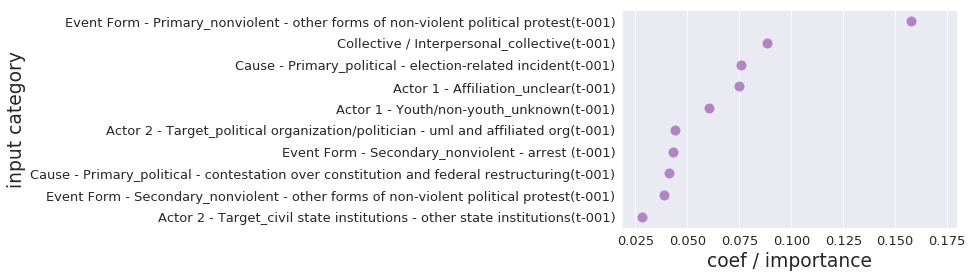

scores  \
                                                         r_2   
Actor 1 - Youth/non-youth_unknown(t)                0.325561   
Collective / Interpersonal_collective(t)            0.318739   
Actor 2 - Youth/non-youth_na(t)                     0.298316   
Violent / Nonviolent_nonviolent(t)                   0.28187   
Actor 2 - Target_political organization/politic...  0.278517   
Cause - Primary_political - election-related in...   0.26042   
Total raped(t)                                      0.198875   
Onesided / Twosided_onesided(t)                     0.193925   
Total injured(t)                                    0.192795   
Actor 2 - Youth/non-youth_unknown(t)                0.185027   

                                                                       \
                                                   explained_variance   
Actor 1 - Youth/non-youth_unknown(t)                         0.330747   
Collective / Interpersonal_collective(t)                     0.319719   
Actor 2 - Youth/non-youth_na(t)                              0.300308   
Violent / Nonviolent_nonviolent(t)                           0.314229   
Actor 2 - Target_political organization/politic...            0.28183   
Cause - Primary_political - election-related in...           0.265766   
Total raped(t)                                               0.289677   
Onesided / Twosided_onesided(t)                               0.19825   
Total injured(t)                                             0.199049   
Actor 2 - Youth/non-youth_unknown(t)                         0.185068   

                                                                            \
                                                   root_mean_squared_error   
Actor 1 - Youth/non-youth_unknown(t)                               19.4967   
Collective / Interpersonal_collective(t)                           22.8227   
Actor 2 - Youth/non-youth_na(t)                                    15.0515   
Violent / Nonviolent_nonviolent(t)                                 9.44435   
Actor 2 - Target_political organization/politic...                  1.8908   
Cause - Primary_political - election-related in...                    23.7   
Total raped(t)                                                     5.23091   
Onesided / Twosided_onesided(t)                                    15.9381   
Total injured(t)                                                   20.3242   
Actor 2 - Youth/non-youth_unknown(t)                               8.93371   

                                                   control_scores  \
                                                              r_2   
Actor 1 - Youth/non-youth_unknown(t)                     0.012414   
Collective / Interpersonal_collective(t)                0.0280466   
Actor 2 - Youth/non-youth_na(t)                         0.0817405   
Violent / Nonviolent_nonviolent(t)                       0.141002   
Actor 2 - Target_political organization/politic...       0.161728   
Cause - Primary_political - election-related in...       0.055514   
Total raped(t)                                         -0.0101023   
Onesided / Twosided_onesided(t)                         -0.142361   
Total injured(t)                                        -0.325367   
Actor 2 - Youth/non-youth_unknown(t)                    -0.359472   

                                                                       \
                                                   explained_variance   
Actor 1 - Youth/non-youth_unknown(t)                        0.0126509   
Collective / Interpersonal_collective(t)                    0.0281704   
Actor 2 - Youth/non-youth_na(t)                             0.0819492   
Violent / Nonviolent_nonviolent(t)                           0.141586   
Actor 2 - Target_political organization/politic...           0.161728   
Cause - Primary_political - election-related in...           0.055514   
Total raped(t)                                            

In [58]:
#call find var again, using params from above.  
model = RandomForestRegressor(random_state=56, **best_params)
    
print("Finding Variables...")
scores, top = find_var(X_week, y_week, model, n_true=20, verbose=2, s_plot=3, n_plot=6)

#extract and plot feature coefs
coefs = get_coefs(X_train, y_train, model)
coefframe = interpret_coefs(coefs,X_train,top.index)

    #print top 10 scores that beat control
top[:10]

In [26]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(random_state=56)
model.get_params(deep=True)

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_iter': 200,
 'momentum': 0.9,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 56,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [59]:
model = MLPRegressor(random_state=56, verbose=True)    
#params = {'n_estimators':range(150,300,1),
#          'warm_start':[False],
#          'max_depth':range(1,300,1),
#          'min_samples_split':np.linspace(0.00000001,.2,100),
#          'min_samples_leaf':range(5,6,1),
#          'min_weight_fraction_leaf':np.linspace(.0000001,.15,100),
#          'max_features':range(150,200,1),
#          'max_leaf_nodes':range(180,300,1),
#          'min_impurity_decrease':np.linspace(0.000001,.6,100)}

MLP_params = {#'activation': ['identity', 'logistic', 'tanh', 'relu'],
     'alpha': np.linspace(0.00000001,.9999999,100),
     'beta_1': np.linspace(0.00000001,.999999,100),
     'beta_2': np.linspace(0.00000001,.999999,100),
     #'early_stopping': [True,False],
     'epsilon':np.linspace(0.00000001,.999999,100),
     'hidden_layer_sizes': [(100,)],# (50,50,), (25,25,25,25,), (12,12,12,12,12,12,12,)],
     'learning_rate': ['adaptive'],
     #'learning_rate_init': np.linspace(0.00000001,10,100),
     'max_iter': range(50,60,1),
     #'momentum': np.linspace(0.00000001,1,100),
     'nesterovs_momentum': [True,False],
     'power_t': np.linspace(0.00000001,.999999,100),
     #'shuffle': [True,False],
     'solver': ['lbfgs'],
     'tol':  np.linspace(0.00000001,.999999,100)}
     #'validation_fraction':  np.linspace(0.00000001,1,100),
     #'warm_start': [False]}

MLP_best_params, MLP_best_score, MLP_results = random_search(MLP_params, model, 100)
print('\nbest parameters',MLP_best_params)
print('best score',best_score)
#Next try plotting parameters next to resulting scores


best parameters {'tol': 0.8282820017171717, 'solver': 'lbfgs', 'power_t': 0.59595900404040403, 'nesterovs_momentum': False, 'max_iter': 54, 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'epsilon': 0.84848400151515146, 'beta_2': 0.3333330066666666, 'beta_1': 0.31313100686868683, 'alpha': 0.1010100998989899}
best score -0.415385410379


plotting 11 params...


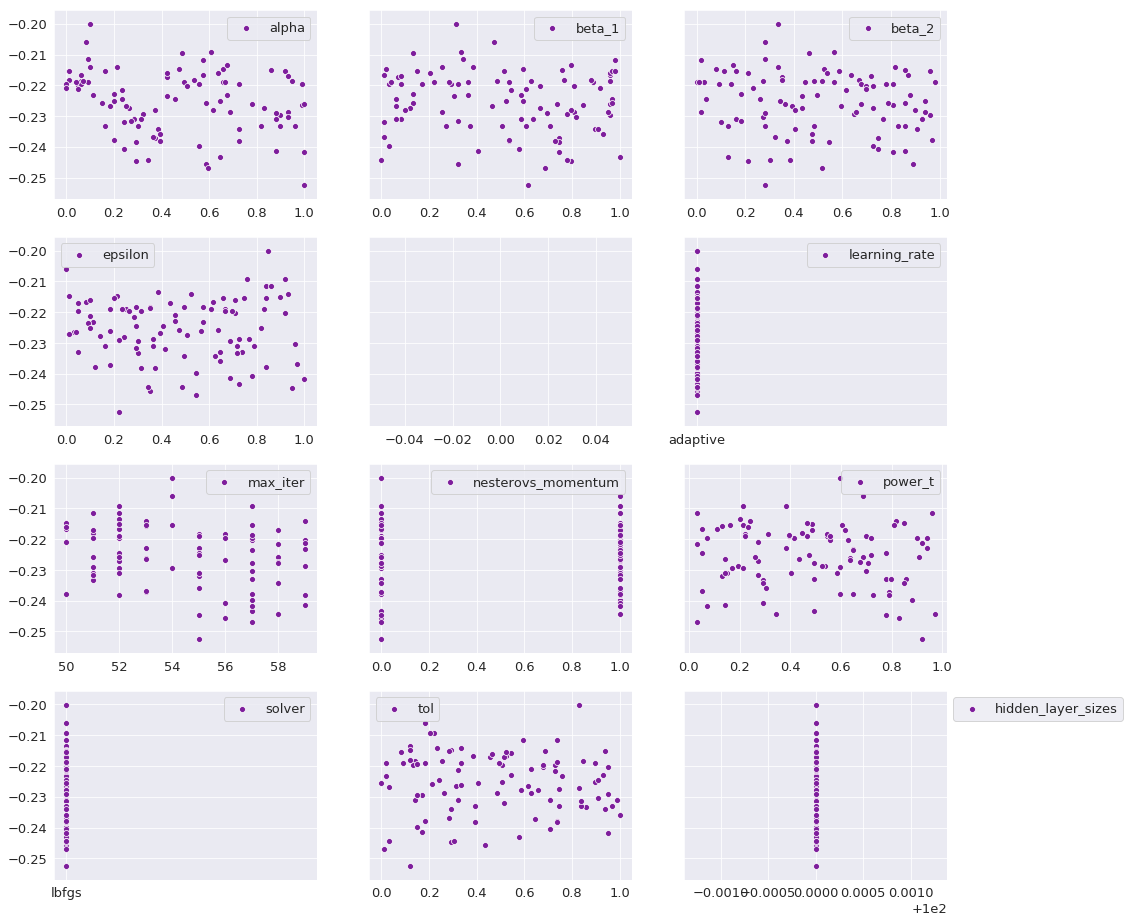

In [60]:
#Plot Results
#for key in MLP_params.keys():
#    try:
#        sns.scatterplot(results['param_'+key],results['mean_test_score'], label=key)
#    except:
#        
#        lst = []
#        for item in results['param_'+key]:
#            lst.append(item[0])
#        #print(lst)
#        sns.scatterplot(lst ,results['mean_test_score'], label=key)
#    plt.legend(bbox_to_anchor=(1,1))
#    plt.show()
plot_params(MLP_params, MLP_results)

Finding Variables...

top score r_2: 0.5210394463528742
top score explained variance: 0.522135871394
best score rmse: 0.753993904484

control test - forcast using exact values of previous week:
top score r_2: 0.402915094814
top score explained variance: 0.402915094814
best score rmse: 0.554700196225

Top Scoring Variables:


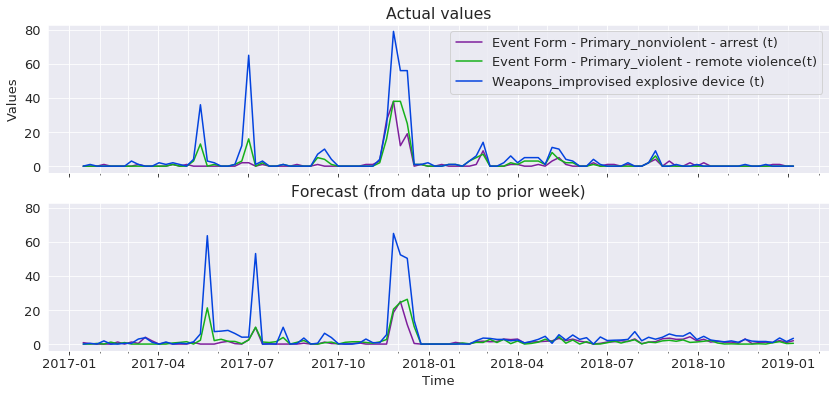

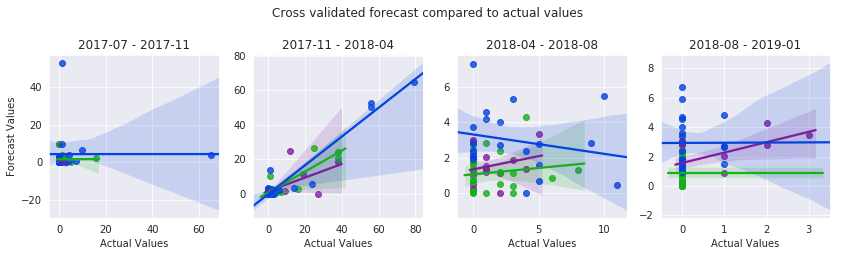

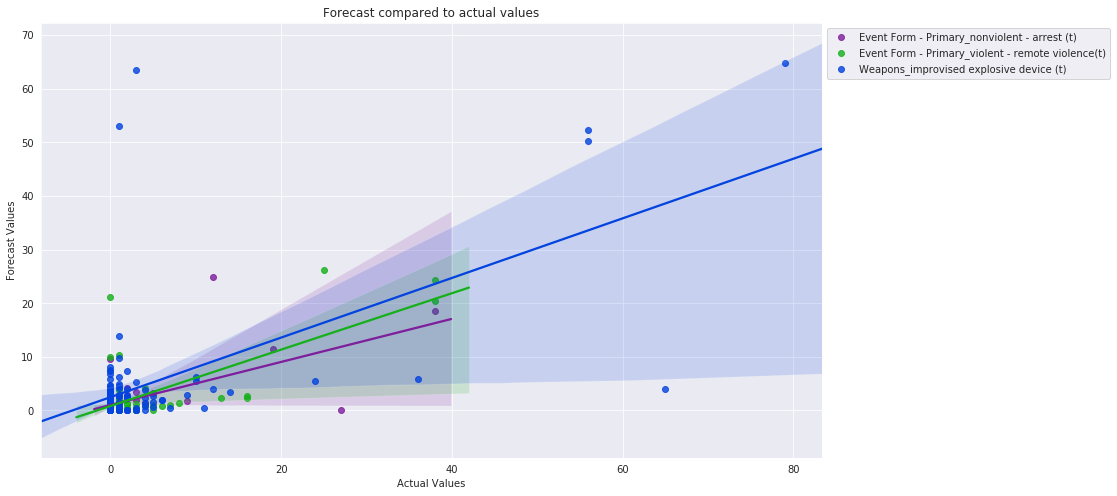

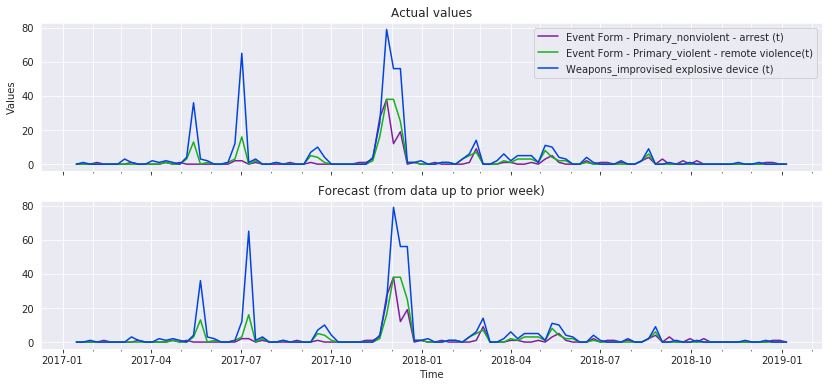

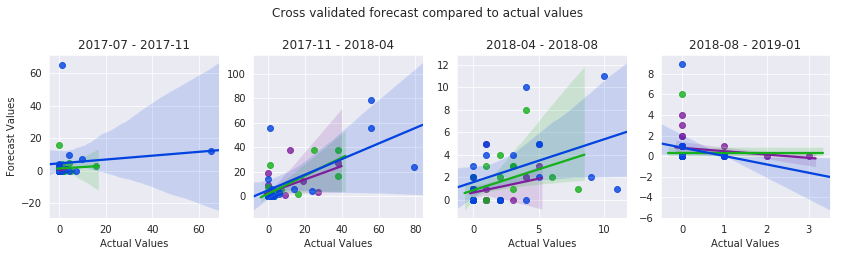

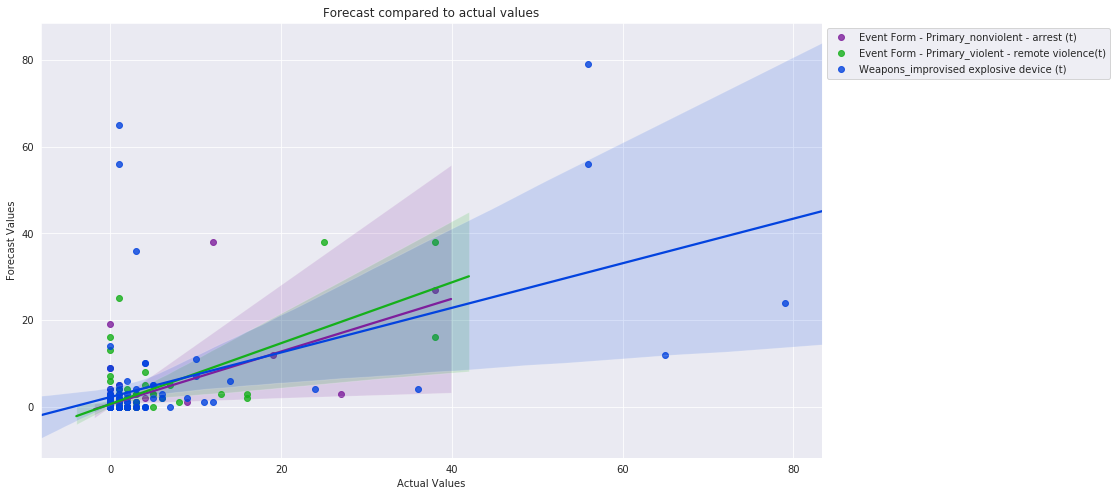

unable to fetch coefs, trying importance...
Failed!
plotting Event Form - Primary_violent - remote violence(t)
plotting Event Form - Primary_nonviolent - arrest (t)


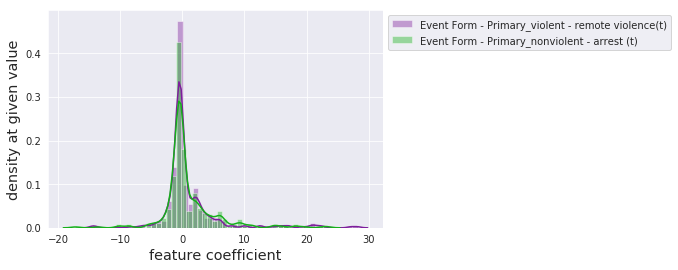

Total feature coefs: (2, 321)


ValueError: Shape of passed values is (321, 2), indices imply (321, 321)

In [61]:
model = MLPRegressor(random_state=56, **MLP_best_params)
    
print("Finding Variables...")
scores, top = find_var(X_week, y_week, model, n_true=20, verbose=2, s_plot=0, n_plot=3)

#extract and plot feature coefs
coefs = get_coefs(X_train, y_train, model)
coefframe = interpret_coefs(coefs,X_train,top.index)

    #print top 10 scores that beat control
top[:10]

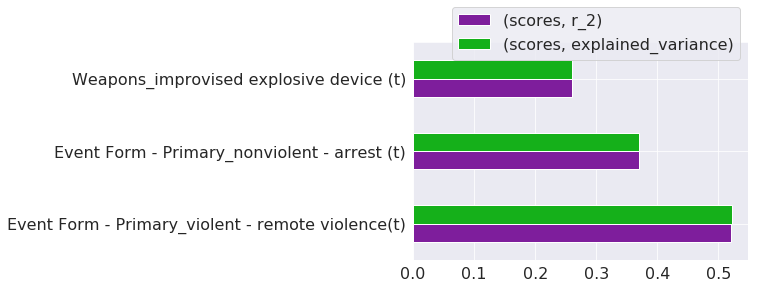

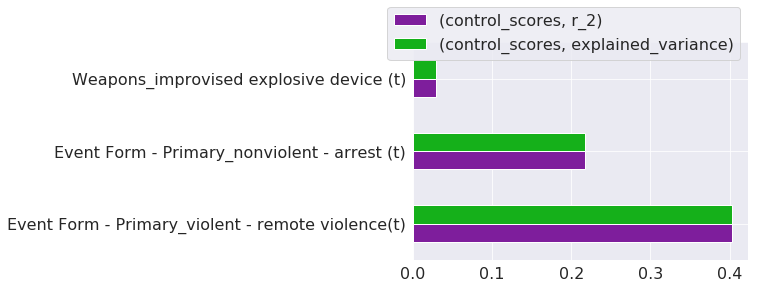

In [62]:
plt.rcParams.update({'font.size': 16})
top.iloc[:3,:2].plot(kind='barh')
plt.legend(bbox_to_anchor=(1,1.2))
plt.show()

#top.iloc[:3,1].plot(kind='barh', color=catpal[2])
#plt.legend(bbox_to_anchor=(1,1.1))
#plt.show()

top.iloc[:3,3:5].plot(kind='barh')
plt.legend(bbox_to_anchor=(1,1.2))
plt.show()

#top.iloc[:3,5].plot(kind='barh', color=catpal[2])
#plt.legend(bbox_to_anchor=(1,1.1))
#plt.show()

Finding Variables...

top score r_2: 0.4817028302704296
top score explained variance: 0.482833587501
best score rmse: 0.770464317045

control test - forcast using exact values of previous week:
top score r_2: 0.402915094814
top score explained variance: 0.402915094814
best score rmse: 0.554700196225

Top Scoring Variables:


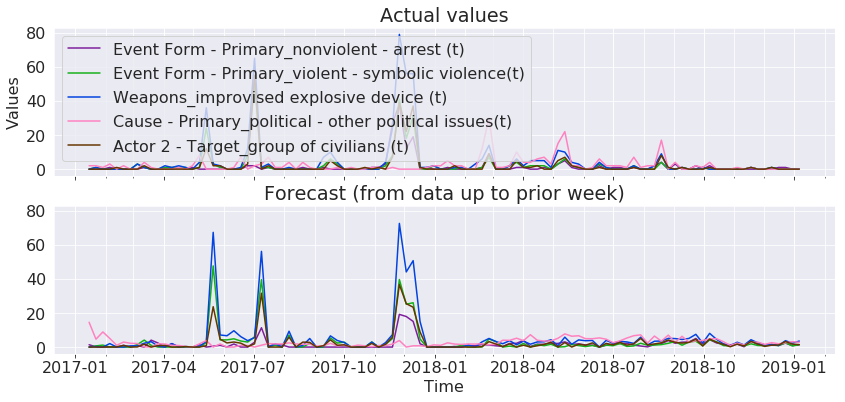

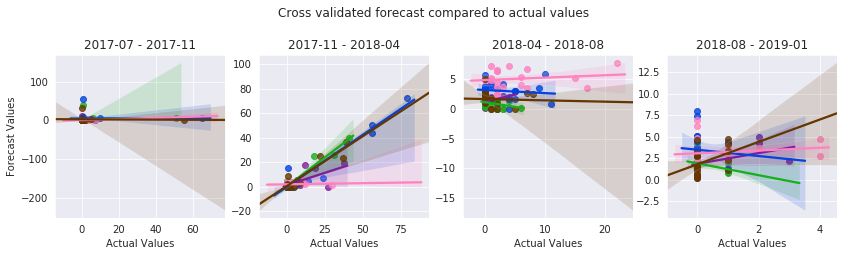

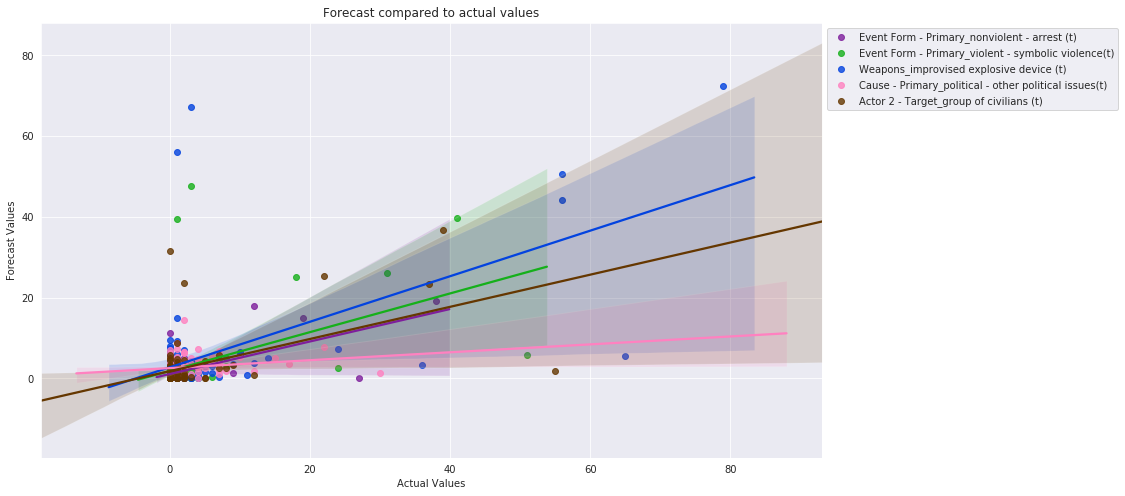

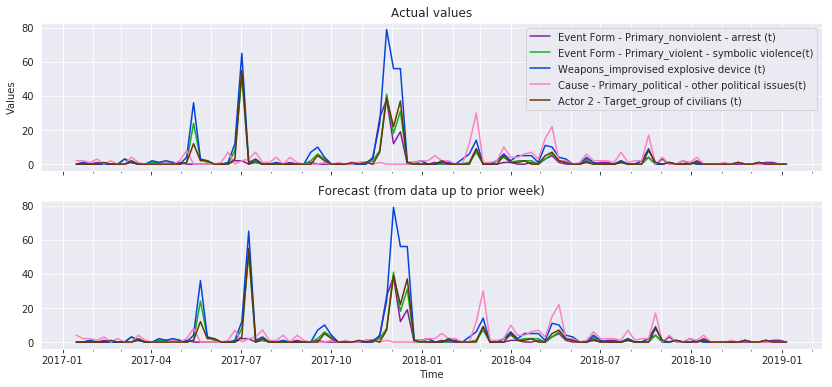

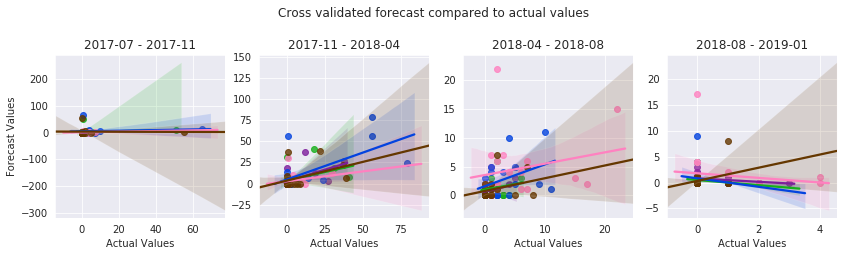

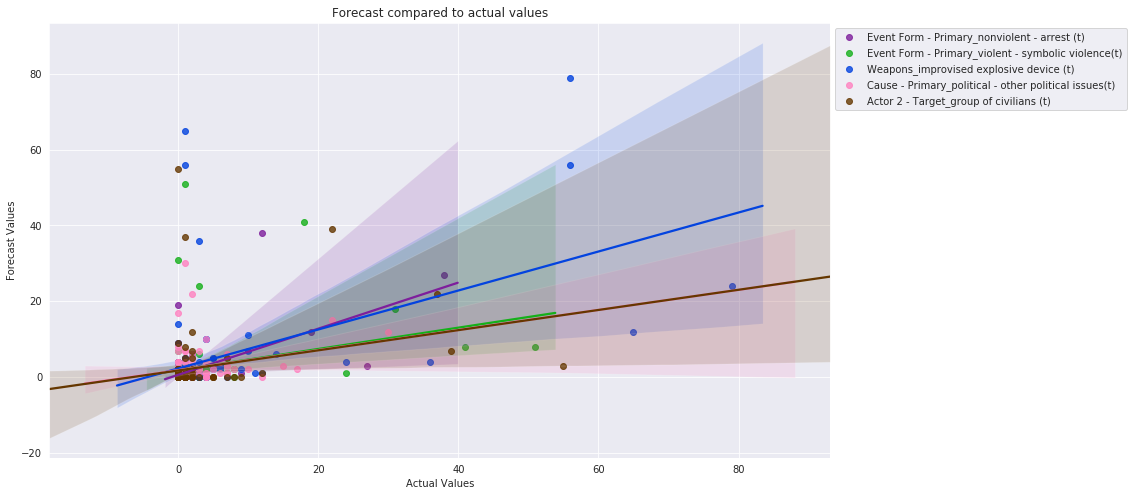

scores  \
                                                          r_2   
Event Form - Primary_nonviolent - arrest (t)         0.420172   
Weapons_improvised explosive device (t)              0.217193   
Actor 2 - Target_group of civilians (t)              0.195151   
Cause - Primary_political - other political iss... -0.0783026   
Event Form - Primary_violent - symbolic violenc...  -0.100628   
Actor 2 - Target_family/relative(t)                 -0.219499   
Actor 1 - Affiliation_political organization/po...  -0.270441   
Female injured(t)                                   -0.302098   
Event Form - Primary_violent - vandalism(t)         -0.332157   
Actor 2 - Target_private sector - private compa...  -0.415617   

                                                                       \
                                                   explained_variance   
Event Form - Primary_nonviolent - arrest (t)                 0.421397   
Weapons_improvised explosive device (t)                      0.220072   
Actor 2 - Target_group of civilians (t)                      0.197268   
Cause - Primary_political - other political iss...         -0.0728954   
Event Form - Primary_violent - symbolic violenc...         -0.0953843   
Actor 2 - Target_family/relative(t)                         -0.218852   
Actor 1 - Affiliation_political organization/po...          -0.258702   
Female injured(t)                                            -0.29719   
Event Form - Primary_violent - vandalism(t)                 -0.316029   
Actor 2 - Target_private sector - private compa...          -0.408528   

                                                                            \
                                                   root_mean_squared_error   
Event Form - Primary_nonviolent - arrest (t)                       3.83504   
Weapons_improvised explosive device (t)                             11.467   
Actor 2 - Target_group of civilians (t)                            7.00454   
Cause - Primary_political - other political iss...                 4.68342   
Event Form - Primary_violent - symbolic violenc...                 7.88444   
Actor 2 - Target_family/relative(t)                                3.13281   
Actor 1 - Affiliation_political organization/po...                 8.72862   
Female injured(t)                                                  2.87977   
Event Form - Primary_violent - vandalism(t)                        3.21281   
Actor 2 - Target_private sector - private compa...                 2.85191   

                                                   control_scores  \
                                                              r_2   
Event Form - Primary_nonviolent - arrest (t)             0.216831   
Weapons_improvised explosive device (t)                 0.0283659   
Actor 2 - Target_group of civilians (t)                 -0.467861   
Cause - Primary_political - other political iss...      -0.469136   
Event Form - Primary_violent - symbolic violenc...      -0.438543   
Actor 2 - Target_family/relative(t)                     -0.370386   
Actor 1 - Affiliation_political organization/po...      -0.496253   
Female injured(t)                                       -0.721079   
Event Form - Primary_violent - vandalism(t)             -0.543737   
Actor 2 - Target_private sector - private compa...      -0.727113   

                                                                       \
                                                   explained_variance   
Event Form - Primary_nonviolent - arrest (t)                 0.216831   
Weapons_improvised explosive device (t)                     0.0283659   
Actor 2 - Target_group of civilians (t)                     -0.467861   
Cause - Primary_political - other political iss...          -0.469063   
Event Form - Primary_violent - symbolic violenc...          -0.438543   
Actor 2 - Target_family/relative(t)                         -0.370283   
Actor 1 - Affiliation_political organization/po

In [31]:
model = MLPRegressor(random_state=56, **MLP_best_params)
    
print("Finding Variables...")
scores, top = find_var(X_week, y_week, model, n_true=20, verbose=2, s_plot=0, n_plot=5)
    #print top 10 scores that beat control
top[:10]

### Comparatively Evaluate Predictive Models

In [32]:
import warnings
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ARDRegression
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import MultiTaskElasticNetCV
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import Perceptron
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import TheilSenRegressor



def search_models(modellist, catlist, verbose=False, random_state=False):
    categories = y_week.columns.tolist()
    scoresdf = pd.DataFrame(index=categories)
    warnings.filterwarnings("ignore")
    for model in modellist:
        #par = model.get_params
        modelstring = str(model).split('(')[0]
        print('\n{}:'.format(modelstring))
        print('Trying Native Multioutput...')
        _, model_scoresdf = find_var(X_week, y_week[catlist], model, n_true=10, verbose=verbose, random_state=random_state)
        print('Top 3 scores:\n',model_scoresdf[('scores','explained_variance')].sort_values(ascending=False)[:3])
        if scoresdf.shape[1] < 3:
            scoresdf = pd.concat([scoresdf, model_scoresdf.iloc[:,3:6]], axis=1)
        
        scoresdf = pd.concat([scoresdf, model_scoresdf.iloc[:,:3]], axis=1)
        #top5 = scoresdf.sort_values(scoresdf.columns.tolist(), axis=0, ascending=False)[:5]
        #top5_col = top5.sort_values(top5.index.tolist(), axis=1, ascending=False).iloc[:,:1]
        #print(top5_col)
        
        #label first section of df < debug later
        new_cols = scoresdf.columns.tolist()
        for x in range(3):
            i = len(new_cols)- 1 - x
            new_cols[i] = (modelstring, new_cols[i][1])
            #print('appended!', modelstring, 'to', new_cols[x][0])
        scoresdf.columns = new_cols
        print('appended', modelstring, 'to columns')
        #except: 
            #print('No longer trying Multi-Output wrapper')
            #print('Failed... Using MultiOutput wrapper')
            #_, model_scoresdf = find_var(X_week, y_week[catlist], MultiOutputRegressor(model, n_jobs=-1), n_true=10, verbose=verbose, random_state=random_state)
           
    print('Bing!')
    return scoresdf

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)
    random_state=56
    modellist=[#LinearRegression(),
               RandomForestRegressor(random_state=random_state,**best_params),
               MLPRegressor(random_state=random_state,**MLP_best_params),
               #BayesianRidge(),
               #ARDRegression(),# <throws a big error
               
               ElasticNet(random_state=random_state),
               #ElasticNetCV(random_state=random_state), < save automatic Cv for holdout sets
               #HuberRegressor(),
               #Lars(random_state=random_state), < tiny results
               Lasso(random_state=random_state)] #add after fixing function
               #MultiTaskLassoCV(random_state=random_state),<way too slow
               #PassiveAggressiveRegressor(random_state=random_state),
               #Perceptron(random_state=random_state),
               #TheilSenRegressor(random_state=random_state)]
               #RidgeCV()]
    
    scoresdf = search_models(modellist, y_week.columns, random_state=random_state)
    scoresdf.head()


RandomForestRegressor:
Trying Native Multioutput...
Top 3 scores:
 Actor 1 - Youth/non-youth_unknown(t)        0.330976
Collective / Interpersonal_collective(t)    0.320132
Violent / Nonviolent_nonviolent(t)          0.313887
Name: (scores, explained_variance), dtype: object
appended RandomForestRegressor to columns

MLPRegressor:
Trying Native Multioutput...
Top 3 scores:
 Actor 2 - Target_group of civilians (t)                  0.237881
Event Form - Primary_violent - symbolic violence(t)     0.0150713
Actor 2 - Target_private sector - private company(t)   -0.0638388
Name: (scores, explained_variance), dtype: object
appended MLPRegressor to columns

ElasticNet:
Trying Native Multioutput...


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
scoresdf

In [ ]:
#top_scores_df = scoresdf.sort_values(scoresdf.columns.tolist(), axis=0, ascending=False).iloc[:10,:]
#top_scores_df.dropna(inplace=True)

#Plot explained variance of scores of various regressors
colr=0
expv = scoresdf.iloc[:,0::3]#.dropna()
expv = expv.sort_values(expv.columns[1], ascending=False)[:30]
f, ax = plt.subplots(1,1, figsize=(8,12))
ax.set_xlim(-.0,.4)
for col in expv.columns:
    #plot = expv.loc[expv[col] > 0]
    if len(expv) > 0:
        sns.barplot(x=col, y=expv.index, data=expv, color=catpal[colr*2], label=col[0], alpha=0.5, ax=ax, dodge=True)
    colr+=1
#sns.barplot(y=expv.index, data=expv, alpha=0.5, ax=ax)    
plt.xlabel(expv.columns[0][1]+' score')
plt.ylabel('output category')
plt.legend(bbox_to_anchor=(-0.02,0))
plt.rcParams.update({'font.size': 20})
plt.show()
        
#for col in scoresdf.columns[2::3]:
    #plot = scoresdf[[col]].sort_values(col).loc[scoresdf[col] < .3]
    #if len(plot) > 0:
        #sns.barplot(x=col, y=plot.index, data=plot)
        #plt.show()
expv.head()

In [ ]:


#plt.figure(figsize=(8,12))
expv[:10].plot(kind='barh', figsize=(8,12))
plt.legend(bbox_to_anchor=(-0.02,0))
plt.xlim(-.0,.5)
plt.show()

In [ ]:
tops = scoresdf.iloc[:,1].sort_values(ascending=False)[:5]
tops

In [ ]:
if __name__ == '__main__': #protect windows from parallel processes(if you run windows)            
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    model = MLPRegressor(random_state=56)
    X_train, X_test, y_train, y_test, y_pred, y_control = try_model(X_week, y_week, model, verbose=False)
    
    #holdout = investigate(tops.index, X_week, y_week, holdout_X_week, holdout_y_week, model, verbose=True, random_state=38)
#holdout.sort_values('explained_variance', ascending=False)

In [ ]:
#lets randome grid search with lookback
import random
from sklearn.linear_model import MultiTaskElasticNetCV

def opt_lookback(df, model):
    '''function to optimize number of units to look back through time'''
    print('Optimizing...')
    scorelist = []
    categories = df.columns.tolist()
    scoredf = pd.DataFrame(index=categories)#need to
    
    #generate a random state for consistent comparisons
    random_state = random.randint(1,1000)
    print('using random_state:', random_state)
    #loop through possible ranges to look back at to find the the optimum value
   
    for lookback in (range(1,50)):
        
        #create a timeshifted dataframe within that range
        time_shift = make_timeshift(df, lookback)
        
        #split timeshift into training and hold out data sets
        X, y, holdout_X, holdout_y = create_X_y(time_shift)
        
        #bandaid fix
        scoredf.index = y.columns.tolist()
        
        
        
        #print(scores.head())
        #find the sum of the crossvalidation scores
        #test = np.sum(scores['cv_mean'])
        
        
        #find which variables recieved a score above 0
        top_scores = scores.loc[scores['explained_variance'] > 0].index.tolist()
        #print(top_scores)
        
        #find sum of scores above 0
        top_sum = np.sum(scores.loc[top_scores,:].iloc[:1])
        
        #use investigate function to see how those variables did against the holdout set
        #holdout_scores = investigate(top_scores, X, y, holdout_X, holdout_y, model, verbose=False, random_state=random_state)             
        #print(holdout_scores.head())
        
        #find the sum of the hold out test scores scores
        #holdout_max = np.max(holdout_scores.loc[:,'explained_variance'])
        #print(holdout_sum)
        
        #print the lookback interval, and mean scores
        #print('\nt-{0} top sum: {1:.2f}, holdout_max: {2:.2f} '.format(lookback,top_sum, holdout_max))
        print('\nt-{0} top sum: {1:.2f},'.format(lookback,top_sum))
        
        #append the crossvalidation score to the list
        scorelist.append(top_sum)#,cv_score)
        
        #join the scores to the data frame of scores
        scoredf = scoredf.join(scores, how='left', sort=False, rsuffix=('(t-'+str(lookback).zfill(3)+')'))
        #scoredf = scoredf.join(holdout_scores, how='left', sort=False, rsuffix='_holdout(t-'+str(lookback).zfill(3)+')')
        #scoredf = pd.concat([scoredf, scores, holdout_scores], axis=1, join_axes=[scoredf.index])
        
        #stop fuction and return scores soon as there is a definate downward trend
        if len(scorelist) > 10:
            if np.median(scorelist[-2:]) < np.median(scorelist[-5:-2]):
                return scoredf

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)            
    
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    model = MLPRegressor(random_state=56, **MLP_params)
    #scoredf_day = opt_lookback(in_day, model)
    scoredf_week = opt_lookback(in_week, model)
    print('bing!')

    scoredf_week.head()
    #plt.plot(scoredf_day)#, label = 'by day')
    #plt.plot(scoredf_week, label = 'by week')
    #plt.title('Mean crossvalidation scores v. lookback times')
    #plt.legend()
    #plt.show()

In [ ]:
#create function to optimize lookback!
import random
from sklearn.linear_model import MultiTaskElasticNetCV

def opt_lookback(df, model):
    '''function to optimize number of units to look back through time'''
    print('Optimizing...')
    scorelist = []
    categories = df.columns.tolist()
    scoredf = pd.DataFrame(index=categories)#need to
    
    #generate a random state for consistent comparisons
    random_state = random.randint(1,1000)
    print('using random_state:', random_state)
    #loop through possible ranges to look back at to find the the optimum value
   
    for lookback in (range(1,50)):
        
        #create a timeshifted dataframe within that range
        time_shift = make_timeshift(df, lookback)
        
        #split timeshift into training and hold out data sets
        X, y, holdout_X, holdout_y = create_X_y(time_shift)
        
        #bandaid fix
        scoredf.index = y.columns.tolist()
        
        #find the scores for all the variables #(those which have more positives than negatives)
        _, scores = find_var(X, y, model, n_true=20, verbose=0, random_state=random_state)
        
        #print(scores.head())
        #find the sum of the crossvalidation scores
        #test = np.sum(scores['cv_mean'])
        
        
        #find which variables recieved a score above 0
        top_scores = scores.loc[scores['explained_variance'] > 0].index.tolist()
        #print(top_scores)
        
        #find sum of scores above 0
        top_sum = np.sum(scores.loc[top_scores,:].iloc[:1])
        
        #use investigate function to see how those variables did against the holdout set
        #holdout_scores = investigate(top_scores, X, y, holdout_X, holdout_y, model, verbose=False, random_state=random_state)             
        #print(holdout_scores.head())
        
        #find the sum of the hold out test scores scores
        #holdout_max = np.max(holdout_scores.loc[:,'explained_variance'])
        #print(holdout_sum)
        
        #print the lookback interval, and mean scores
        #print('\nt-{0} top sum: {1:.2f}, holdout_max: {2:.2f} '.format(lookback,top_sum, holdout_max))
        print('\nt-{0} top sum: {1:.2f},'.format(lookback,top_sum))
        
        #append the crossvalidation score to the list
        scorelist.append(top_sum)#,cv_score)
        
        #join the scores to the data frame of scores
        scoredf = scoredf.join(scores, how='left', sort=False, rsuffix=('(t-'+str(lookback).zfill(3)+')'))
        #scoredf = scoredf.join(holdout_scores, how='left', sort=False, rsuffix='_holdout(t-'+str(lookback).zfill(3)+')')
        #scoredf = pd.concat([scoredf, scores, holdout_scores], axis=1, join_axes=[scoredf.index])
        
        #stop fuction and return scores soon as there is a definate downward trend
        if len(scorelist) > 10:
            if np.median(scorelist[-2:]) < np.median(scorelist[-5:-2]):
                return scoredf

if __name__ == '__main__': #protect windows from parallel processes(if you run windows)            
    
    #model = MultiOutputRegressor(BayesianRidge(), n_jobs=-1)
    model = MLPRegressor(random_state=56, **MLP_params)
    #scoredf_day = opt_lookback(in_day, model)
    scoredf_week = opt_lookback(in_week, model)
    print('bing!')

    scoredf_week.head()
    #plt.plot(scoredf_day)#, label = 'by day')
    #plt.plot(scoredf_week, label = 'by week')
    #plt.title('Mean crossvalidation scores v. lookback times')
    #plt.legend()
    #plt.show()

In [ ]:
scoredf_week
#scoredf_week['cv_mean'].sum()
#scoredf_week.iloc[:,::4]

In [ ]:
def plot_frame(df, start):
    plotframe = df.iloc[:,start::3]#.sort_values(df.columns[start::4].tolist(), axis=0, ascending=False)[:10]
    meanlist = pd.Series([plotframe.loc[x,:].mean() for x in plotframe.index], index=plotframe.index)
    plotvar = plotframe.loc[meanlist.sort_values(ascending=False)[:10].index]
    #sortvar = plotvar.sort_index(axis=1, ascending=False)
    for label in plotvar.index:
        plt.plot(plotvar.loc[label,:], label=label)

    plt.xticks(rotation=90)
    #plt.ylim(-1,1)
    plt.legend(bbox_to_anchor=(1,1))
    plt.title('Top 10 '+plotvar.columns[0])
    plt.show()
    #print(plotvar)

#print('day')
#for start in [0,1,3,5,7]:
    #plot_frame(scoredf_day, start)

print('week')
for start in [0,1,2]:
    plot_frame(scoredf_week, start)
    


The appears to be a sweet spot around 6. There is a peak in the r_2 / ev sums and a dip in rmse. Let's see what that looks like.

In [ ]:
#create a timeshifted dataframe within that range
time_shift_try = make_timeshift(in_week, 4)
        
#split timeshift into training and hold out data sets
X, y, holdout_X, holdout_y = create_X_y(time_shift_try)
        
#model = RandomForestRegressor(random_state=56)
    
#scores = find_var(X, y, model, n_true=20, verbose=2)
#top = scores.loc[scores['explained_variance'] > .2].sort_values('explained_variance', ascending=False)

In [16]:
X.tail()

NameError: name 'X' is not defined

In [17]:
y.tail()

Total killed(t)  Total injured(t)
Province   Event Date                                   
province 7 2018-12-02              0.0               0.0
           2018-12-09              0.0               0.0
           2018-12-16              0.0               0.0
           2018-12-23              0.0               0.0
           2018-12-30              1.0               1.0

In [18]:
#next is to grid search parameters for tuning... don't forget crossvalidation. it's needed for the outliers
#also sliding window....
#put in a "control" that just uses the previous weeks score. 
